## Teknisk Fysikk Prosjekt 2
### TMA4320 Introduksjon til vitenskapelige beregninger, vår 2022

#### Innledning
I dette prosjektet studeres dynamikk og mekanikk forbundet med vugging og bevegelse av et skip. Det ble benyttet en enkel skipsmodell til å undersøke hvordan faktorer som massesenterbevegelse, friksjonskrefter, oppdrift, vind, bølger og bevegelig last påvirker skipets bevegelse og utslag fra likevektsposisjon. Til dette ble det benyttet ulike algoritmer for løsing av ordinære differensiallikninger, og virkningsgraden deres sammenliknet. Vi har benyttet generell mekanisk fysikk, mer spesifikt Newtons 2.lov for summen av krefter og dreiemoment, for å utlede koblede differentiallikninger som beskriver henholdsvis akselerasjonen til skipets massesenter og vinkelakselerasjon til utsvinget fra likevekt. Ved å benytte iterative metoder brukt for vitenskapelige beregninger, kunne vi ut fra disse løse oss fram til posisjonener, hastigheter vinkelutslag og vinkelhastigheter. Ved å studere utviklingen av disse størrelsene over tid, har vi fått et godt inntrykk av ulike faktorers innspill til dynamikken og mekanikken forbundet med skipsmodellen vår. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.optimize import curve_fit

#### Skipsmodell

I dette prosjektet tas det utgangspunkt i en halvsirkelformet skipsmodell med radius $R=10$ m og uendelig utstrekning i $z$-retning. Videre begrenses skipets bevegelse til $xy$-planet, mens vuggingen, altså den regelmessige rotasjonen frem og tilbake, til å foregå kun om en akse i skipets lengderetning. Det antas dessuten at skipet er kompakt og bygget ett bestemt materiale, slik at det har en konstant massetetthet per flateenhet $\sigma=500$ kg/m$^2$. Dermed vil massesenteret $C$ befinne seg en i avstand

$\displaystyle h = \frac{4R}{3\pi}$

fra skipets midtpunkt/metasenter $M$. M. Fartøyet vil da også få et konstant tverrsnittareal $A_s=\pi R^2 /2$ m$^2$, og dermed få en konstant masse per lengdeenhet $m=A_s\sigma$ kg. Massetettheten til vann per lengdeenhet settes lik $\sigma_0 = 1000$ kg/m$^2$.

![figur](https://imgur.com/uqZXZKK.jpg)
**Figur 1:** Skipsmodell med relevante størrelser sett langs lengderetningen

Treghetsmomentet $I_M$, med hensyn på en akse gjennom midtpunktet $M$, er halvparten av treghetsmomentet til en kompakt, sirkulær sylinder med masse $2m$:

$\displaystyle I_M = \frac{1}{2}\cdot\frac{1}{2}\cdot2mR^2=\frac{mR^2}{2}.$

Steiners sats gir da $I_C = I_M-mh^2$ med $h = 4R/3\pi$, slik at skipets treghetsmoment med hensyn på en akse gjennom massesenteret $C$ blir:

$\displaystyle I_C = \frac{mR^2}{2}-m\left(\frac{4R}{3\pi}\right)^2=\frac{mR^2}{2}-\frac{16mR^2}{9\pi^2}=\frac{1}{2}mR^2 \left(1-\frac{32}{9\pi^2}\right).$

Disse størrelsene forblir konstante gjennom store deler av prosjektet, og derfor defineres disse i starten som globale variabler.

##### Parametre:

In [2]:
#Parametre:

mass_density_water = 1000  # σ_0
mass_density_ship = 500    # σ
R = 10                     # Skipets radius
cross_section = 1/2 * np.pi * R**2 # Skipets tversnittareal
g = 9.81                   # Tyngedeakselerasjonen

m = cross_section*mass_density_ship # Skipets masse per lengdeenhet

I_C = 1/2 * m * R**2 * (1-32/(9*np.pi**2))  # Treghetsmoment om massesenteret

h = 4*R/(3*np.pi)                   # Høydeforskjell mellom masse- og metasenter

Når skipet plasseres i vann, vil det fortrenge en vannmengde, lik tversnittarealet av den delen av skipet som befinner seg under vannoverflaten. Hvis fartøyet er i likevekt, altså når dekket er parallelt med vannoverflaten, angis tverrsnittsarealet $A_0$ til et kompakt skip, ved Arkimedes' lov: 

$\displaystyle A_0 = \frac{\sigma \pi R^2}{2 \sigma_0}. \qquad \text{(1)}$

For å beregne den fortrengte vannmengden benyttes sektorvinkelen mellom vannstandens kontaktpunkt med skipet, på begge sider. Denne vinkelen betegnes $\beta$, noe som gir et sektorareal lik $\beta R^2/2$. Trekanten over vann, illustrert i figur 2, har da et areal

$\displaystyle R \sin({\beta/2}) \cdot R \cos({\beta/2}) = \frac{1}{2}R^2\sin\beta. $

Dermed blir arealet av det fortrengte vannet lik differansen mellom sektorarealet og arealet av trekanten, nemlig:

$\displaystyle A_0 = \frac{1}{2}R^2 (\beta - \sin \beta). \qquad \text{(2)}$

Ved å sette de to uttrykkene for fortrengt vannmengde lik hverandre, henholdsvis likning $(1)$ og $(2)$, oppnås et uttrykk for sektorvinkelen i likevekt fra, kun avnhengig av massetetthetene til skipet og vannet:

$\displaystyle\beta - \sin \beta = \frac{\sigma \pi}{\sigma_0}.$

For å finne en verdi for $\beta$ benyttes Newtons metode for å løse denne fikspunktlikningen, og lar 

$\displaystyle f(\beta) = \beta - \sin \beta - \frac{\sigma \pi}{\sigma_0} \hspace{0.2cm} \Rightarrow \hspace{0.2cm} f'(\beta) = 1 - \cos \beta.$

Ved å finne sektorvinkelen $\beta$ kan en bestemme hvor mye av skipet som er i kontakt med vannet, når skipet er i likevekt.

![figur](https://imgur.com/i89NXrR.jpg)
**Figur 2:** Sektorvinkel $\beta$ og tversnittareal under vann ved likevekt

Newtons metode er definert slik at hvis den $i$-te approksimasjonen er $x_i$, og $f'(x_i)\neq0$, så er den neste approksimasjonen gitt ved:

$\displaystyle x_{i+1} = x_i - \frac{f(x_n)}{f'(x_n)}$

In [3]:
# Oppgave 1a)

def newton(f, df, x0, tol=1.e-8, max_iter=30):      #Newtons metode
    ''' Solve f(x)=0 by Newtons method
        The output of each iteration is printed
        Input:
        f, df:   The function f and its derivate f'.
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''
    x = x0
    for k in range(max_iter):
        fx = f(x)
        if np.linalg.norm(fx, -np.inf) < tol:           # Accept the solution
            break
        x = x - fx/df(x)            # Newton-iteration
    return x, k+1

def f_beta(beta, mass_density=mass_density_ship):
    return beta-np.sin(beta)-np.pi*mass_density_ship/mass_density_water

def df_beta(beta):
    return 1-np.cos(beta)

In [4]:
beta0 = np.array([1.5])        # Starting value
beta, nit = newton(f_beta, df_beta, beta0, tol=1.e-14, max_iter=15)  # Apply Newton
beta = beta[0]
print(f"Sektorvinkelen av skipets kontaktflate med vann i likevekt:")
print(f"\tbeta = {beta*180/np.pi:.2f} \n\tnumber of iterations = {nit:d}")

Sektorvinkelen av skipets kontaktflate med vann i likevekt:
	beta = 132.35 
	number of iterations = 6


Med massetetthetene $\sigma$ og $\sigma_0$ definert over oppnås sektorvinkel $\beta = 2.30988 \text{ rad} \approx 132.35^{\circ}$. Dette virker som et rimelig resultat, sammeliknet med figur 2.

Videre betegnes tyngdepunktet til det fortrengte vannet som $B$, og sektorvinkelen mellom vannstandens kontaktpunkter som $\gamma$ når skipet er ute av likevekt, som gir en avstand fra skipets midtpunkt $M$ til $B$ lik:

$\displaystyle Y_{MB} = R \cdot \frac{4 \sin^3(\gamma/2)}{3(\gamma-\sin\gamma)}$

Ved ren rotasjon om massesenteret $C$, vil metasenteret $M$ følge en sirkelbane med radius $h$ og sentrum $C$. Ved en rotasjonsvinkel $\theta$, forflyttes derfor $M$ vertikalt $\Delta y_M = h (\cos\theta-1)$ og horisontalt $\Delta x_M = -h\sin\theta$.

Skipets dypeste punkt betegnes $D$, der avstanden $Y_{MD}=R$ alltid. Posisjonene for det fortrengte vannets tyngdepunkt $B$ og skipets dypeste punkt $D$ vil alltid befinne seg vertikalt rett under midtpunktet $M$, og får derfor samme horisontale forflytning som $M$. De vertikale posisjonene til punktene av interesse kan listes opp som følger:

I likevekt:

$\displaystyle y_M^0 = R\cos(\beta/2),$

$\displaystyle y_C^0 = y_M^0 - h = R\cos(\beta/2)-\frac{4R}{3\pi},$

$\displaystyle y_B^0 = y_M^0 - Y_{MB}^0 =  R\cos(\beta/2) - \frac{4R \sin^3(\gamma/2)}{3(\gamma-\sin\gamma)},$

$\displaystyle y_D^0 = y_M^0 - R = R\cos(\beta/2) - R.$

![figur](https://imgur.com/eb6s71a.jpg)
**Figur 3:** Vertikale pukter av interesse ved likevekt

Ved rotasjon $\theta$ om $C$:

$\displaystyle y_M^\theta = y_M^0 - \Delta y_M = R\cos(\beta/2) + \frac{4R}{3\pi}(\cos\theta -1),$

$\displaystyle y_C^\theta = y_C^0 = R\cos(\beta/2)-\frac{4R}{3\pi},$

$\displaystyle y_B^\theta = y_M^\theta - Y_{MB}^\theta = R\cos(\beta/2) + \frac{4R}{3\pi}(\cos\theta -1) - \frac{4R \sin^3(\gamma/2)}{3(\gamma-\sin\gamma)},$

$\displaystyle y_D^\theta = y_D^0 - \Delta y_M = R\cos(\beta/2) - R + \frac{4R}{3\pi}(\cos\theta -1).$

![figur](https://imgur.com/6s39V1S.jpg)
**Figur 4:**  Vertikale størrelser av interesse ved rotasjon $\theta$

Ved rotasjon $\theta$ og vertikal translasjon $\Delta y_C$:

$\displaystyle y_M = R\cos(\beta/2) + \frac{4R}{3\pi}(\cos\theta -1) + \Delta y_C,$

$\displaystyle y_C = R\cos(\beta/2)-\frac{4R}{3\pi} + \Delta y_C, \qquad \text{(3)}$

$\displaystyle y_B = R\cos(\beta/2) + \frac{4R}{3\pi}(\cos\theta -1) - \frac{4R \sin^3(\gamma/2)}{3(\gamma-\sin\gamma)} + \Delta y_C,$

$\displaystyle y_D = R\cos(\beta/2) - R + \frac{4R}{3\pi}(\cos\theta -1) + \Delta y_C.$

![figur](https://imgur.com/TGRaUyM.jpg)
**Figur 5:** Vertikale størrelser av interesse ved rotasjon $\theta$ og forflytning $\Delta y_C$

Sektorvinkelen $\gamma$ avhenger av rotert vinkel $\theta$ og vertikal forflytning $\Delta y_C$, og oppfyller $\cos (\gamma/2) = y_M/R$, slik at:

$\displaystyle \gamma = 2 \arccos [\cos(\beta/2)-(4/3\pi)(1-\cos\theta)+\Delta y_C/R]. \qquad \text{(4)}$

Arealet av det fortrengte vannet blir da $\displaystyle A = \frac{1}{2}R^2(\gamma-\sin\gamma)$. 

Vannoverflaten defineres til $y=0$. Med den beregnete verdien av $\beta$ kan likningene ovenfor kan benyttes til å kalkulere høyden over vannlinjen til metasenteret $y_M^0$, skipets massesenter $y_C^0$, skipets dypeste punkt $y_D^0$, og angrepspunktet til oppdriftskraften $y_B^0$.

In [5]:
# Oppgave 1b)

def y_M0(R, beta):
    """
    parametere: R, radius på båten, eller bredden på halve dekket.
                beta, sektorvinkelen på skipet i likevekt fra vannkant til vannkant.
    returnerer: høyden fra metasenteret til vannstanden.
    """
    return R*np.cos(beta/2)

def y_C0(R, beta):
    """
    parametere: R, radius på båten, eller bredden på halve dekket.
                beta, sektorvinkelen på skipet i likevekt fra vannkant til vannkant.
    returnerer: høyden fra massesenteretenteret til båten til vannstanden.
    """
    return R*np.cos(beta/2) - 4*R/(3*np.pi)

def y_B0(R, beta):
    """
    parametere: R, radius på båten, eller bredden på halve dekket.
                beta, sektorvinkelen på skipet i likevekt fra vannkant til vannkant.
    returnerer: høyden fra massesenteret til det fortrengte vannet til vannstanden.
    """
    return R*np.cos(beta/2) - 4*R*(np.sin(beta/2))**3/(3*(beta - np.sin(beta)))

def y_D0(R, beta):
    """
    parametere: R, radius på båten, eller bredden på halve dekket.
                beta, sektorvinkelen på skipet i likevekt fra vannkant til vannkant.
    returnerer: høyden fra bunnen av båten til vannstanden.
    """
    return R*np.cos(beta/2) - R

print(f'y_M0: {y_M0(R, beta):.2f} m \ny_C0: {y_C0(R, beta):.2f} m \ny_B0: {y_B0(R, beta):.2f} m \ny_D0: {y_D0(R, beta):.2f} m')

y_M0: 4.04 m 
y_C0: -0.20 m 
y_B0: -2.46 m 
y_D0: -5.96 m


Tyngdepunktet til skipet ligger altså $20$cm under vannoverflaten, som er et rimelig resultat, da massetettheten til båten er halvparten av massetettheten til vannet. Det samme gjelder posisjonen til midten av dekket og bunnen av båten. I tillegg er angrepspunktet til oppdriften plassert i samsvar med forventningene, da den ligger litt nærmere vannkanten enn bunnen av skipet. Alle disse punktene ligger i utgangspunktet i $x = 0$.

Fortegnet til størrelsene angir om punktet av interesse befinner seg over (positiv) eller under (negativ) vannoverflaten. Det observeres at skipets massesenter $C$ befinner seg under vannoverflaten, som ikke korresponderer helt med figurene ovenfor, da disse er laget med hensikt å visualisere hvilke punkter og størrelser som er av interesse, og er ikke laget med eksakte kalkulasjoner.

Oppdriften $F_B$ er netto normalkraft på skipet fra det omgivende vannet, gitt ved Arkimedes' lov som tyngden av det fortrengte vannet, $|F_B| = A\sigma_0g$. Ved likevekt er oppdriften lik skipets tyngde $|F_B|=|F_G|=mg=A_0\sigma_0g$. Utenfor likevekt er oppdriften ikke lik tyngden av skipet, noe som resulterer i et dreiemoment, og dermed en vugge-bevegelse. Dersom det antas at tyngdekraften og oppdriften er de eneste kreftene som virker på skipet, og at bevegelsen til skipets massesenter kan neglisjeres, kan hele skipets dynamikk beskrives ved rotasjonsbevegelsen:

$\displaystyle\sum\tau = I_C\ddot{\theta} = I_C\frac{d\omega}{dt},$

der alle dreiemomentene peker i $z$-retning. Med kun tyngdekraften $\displaystyle \vec{F}_G = -mg\hat{y}$ og oppdriften $\displaystyle \vec{F}_B = A\sigma_0 g\hat{y}$, blir det eneste bidraget til dreiemomentet lik det som virker på massesenteret til det fortrengte vannet, altså; $\displaystyle\tau_B = -F_B h\sin\theta$. Dette gir:

$\displaystyle\frac{d\omega}{dt} = \frac{\tau_B}{I_C} = -\frac{A\sigma_0gh\sin\theta}{I_C}.$

Det antas så videre at mengden fortrengt vann ikke endrer seg når skipet beveges, slik at $\displaystyle A \rightarrow \displaystyle A_0 = \frac{\sigma \pi R^2}{2 \sigma_0}$. Dermed kan det utledes videre at: 

$
\displaystyle\frac{d\omega}{dt} = -\frac{\displaystyle\frac{\sigma \pi R^2}{2 \sigma_0}\sigma_0gh\sin\theta}{I_C}  = -\frac{\sigma \pi R^2gh\sin\theta}{2I_C}
$

![figur](https://imgur.com/gXWTckE.jpg)
**Figur 6:** Tyngdekraft, oppdrift og dreiemoment fra oppdrift

Det opprettes så en vektor med løsninger, gitt ved $\displaystyle\vec{w}(t) = [\theta(t)\quad\omega(t)]^T$, der $\displaystyle\omega = \frac{d\theta}{dt}$, slik at den andreordens
differensialligningen gitt ved rotasjonsbevegelsen kan omskrives til likningssystemet;


$$\label{(1)}
\displaystyle\frac{d\vec{w}}{dt} = \left[\frac{d\theta}{dt} \quad \frac{d\omega}{dt}\right]^T = \left[\omega(t) \quad -\frac{\sigma \pi R^2gh\sin\theta}{2I_C} \right]^T = \vec{f}(t, \vec{w}).
$$

Dette uttrykket kan brukes til å løse ODE-en numerisk ved hjelp av Eulers metode, gitt ved $\vec{w}_{i+1}=\vec{w}_i+h\vec{f}(t_i,\vec{w}_i)$, der $h$ beskriver avstanden mellom de diskrete tidsverdiene $\{t_i\}$. Benytter initialverdiene $\theta(t=0)=20^{\circ}$ og $\omega(t=0)=0$, og plotter $\theta$ som en funksjon av $t$, fra $t = 0$ til $t = 20$ s.

In [6]:
# Oppgave 1d)

def euler(f, t, z, step_length):
    """
    parametere: f, likningssystemet vi ønsker å løse.
                t, tiden gitt i sekunder.
                z, array med løsningen på systemet.
                step_length, lengden på vært steg for en iterasjon.
    returnerer: neste tidssteg med tilhørende løsning.
    """
    z_next = z + step_length*f(t, z)
    t_next = t + step_length
    return t_next, z_next

# Under følger en generell ODE-løser, som skal fungere i de resterende deloppgavene
def ode_solver(f, t0, tend, z0, step_length, method, beta=beta, cap=False, cargo=False, fence=False): 
    '''
    parametere: f, likningssystemet vi ønsker å løse.
                t0, starttidspunkt.
                tend, sluttidspunkt.
                z0, initialbetingelsene.
                step_length, lengden på vært steg for en iterasjon.
                method, løsningsmetode.
    returnerer: løsningen på systemet for hver t i t_num.
    '''

    #Initialiserer:
    z_num = np.array([z0])    # Array for løsningene z 
    t_num = np.array([t0])    # Array for t-verdiene

    tn = t0                # Løpende verdier for t og z
    zn = z0 
    t_cap = np.zeros(1)
    t_lost = np.zeros(1)
    f_original = f
    # Main loop
    while tn < tend - 1.e-10:            # Buffer for truncation errors
        tn, zn = method(f, tn, zn, step_length)    # Do one step by the method of choice
        if cap:
            if check_capsize(zn[0], zn[3], beta) or f==f_cap: 
                if len(zn)==8:
                    zn=np.array([np.sign(zn[0])*np.pi/2, 0, 0, 0, 0, 0, 0, 0])
                else:
                    zn=np.array([np.sign(zn[0])*np.pi/2, 0, 0, 0, 0, 0])
                t_cap = np.append(t_cap,tn)
                f=f_cap
        if cargo and not fence:
            if abs(zn[6]) > R:
                zn[6] = 0 #np.sign(zn[6])*(R+1)
                zn[7] = 0
                t_lost = np.append(t_lost, tn)
                f = f_lost
        if cargo and fence:
            if abs(zn[6]) > R:
                zn[6] = np.sign(zn[6])*(R)
                zn[7] = 0
                t_lost = np.append(t_lost, tn)
                f = f_lost_fence
            if np.sign(zn[1])!=np.sign(zn[6]): f = f_original
        z_num = np.concatenate((z_num, np.array([zn])))
        t_num = np.append(t_num, tn)
        
    if len(t_cap)>1: t_cap = t_cap[1]
    else: t_cap=-1 
    if len(t_lost)>1: t_lost = t_lost[1]
    else: t_lost=-1
    return t_num, z_num, t_cap, t_lost

In [7]:
def f_1d(t, z):
    dw = np.array([z[1], -mass_density_ship*np.pi*R**2*g*h*np.sin(z[0])/(2*I_C)])
    return dw

# initialbetingelser
t0, tend = 0, 20
z0_1d = np.array([20*np.pi/180, 0])
step_length = 0.001 #bør være så liten som mulig

t_num_1d, z_num_1d, t_cap_1d, t_lost_1d = ode_solver(f_1d, t0, tend, z0_1d, step_length, euler)
np.savez('1d', time = t_num_1d, angles = z_num_1d[:,0], angular_velocity = z_num_1d[:,1])


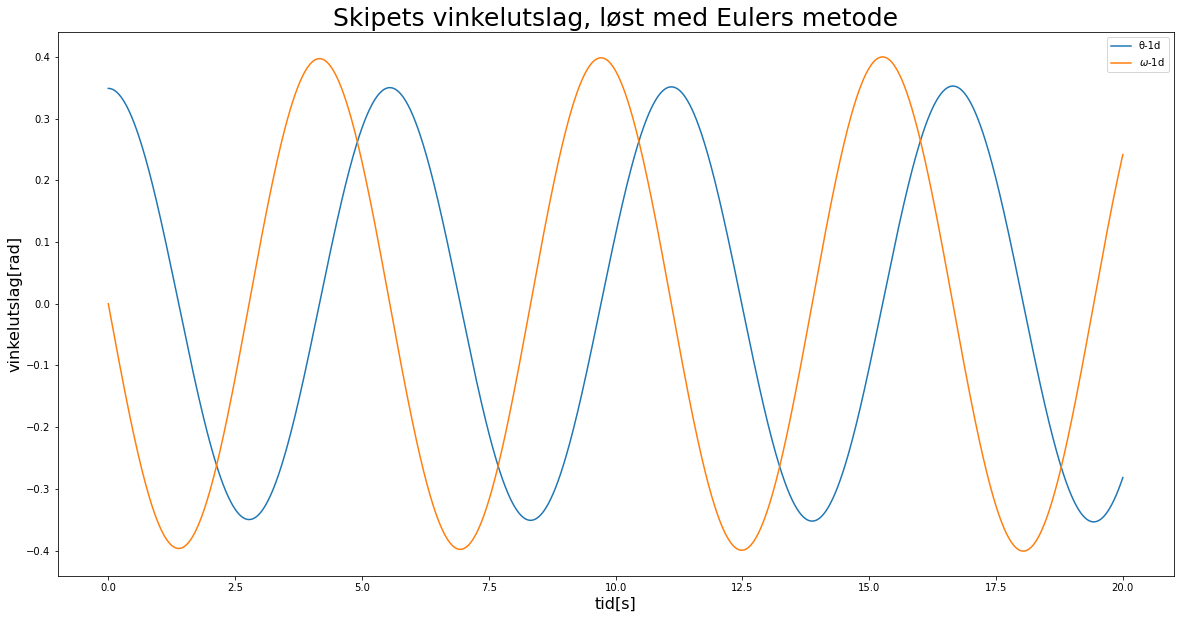

In [8]:
data_1d = np.load('1d.npz')

plt.figure(figsize = (20, 10))
plt.plot(data_1d['time'], data_1d['angles'])
plt.plot(data_1d['time'], data_1d['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med Eulers metode', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ-1d', '$\omega$-1d'])
plt.show()

Ved å utføre Eulers metode for ulike steglengder ble det oppnådd store variasjoner i resultatene. Dette skyldes at Eulers metode er av orden 1, og har ingen implementert steglegdekontroll. For å optimalisere rimeligheten av resultatet, ble det valgt en så liten steglengde som mulig, men som likevel resulterte i en akteptabel kjøretid. Det ble derfor valgt $h=0.001$.

Det observeres at skipet svinger som en harmonisk pendel. Dette skyldes at systemet på dette punktet er meget forenklet. De eneste ytre kreftene som her er blitt implementert er oppdriften og tyngdekraften. Det betyr at pendelen ikke møter motstand, og det er dermed ingen krefter som bremser den. Da vil den svinge harmonisk inn i uendeligheten. 

For små vinkelutslag $\theta \ll 1$ kan det approksimeres $\sin\theta \approx \theta$. Hvis det så antas at $|F_B|=|F_G|=mg$, fås det at Newtons 2. lov for rotasjon om C blir:

$
\displaystyle\sum\tau = \tau_B = -F_B h\sin\theta = -mgh\sin\theta \approx -mgh\theta = I_C\ddot{\theta} = I_C\frac{d\omega}{dt} \quad \Rightarrow \quad \frac{d\omega}{dt} = \frac{-mgh\theta}{I_C}.
$

Forrige numeriske utregning gjentas, men nå med denne småvinkelapproksimasjonen, for startvinklene $\theta_0=1^{\circ}$ og $\theta_0=20^{\circ}$. 

In [9]:
# Oppgave 1e)

def f_1e(t, z):
    dw = np.array([z[1], -m*g*h*z[0]/I_C])
    return dw

step_length = 0.001

z0_1e = [20*np.pi/180,0]

t_num_1e, z_num_1e, t_cap_1e, t_lost_1e = ode_solver(f_1e, t0, tend, z0_1e, step_length, euler)
np.savez('1e_20_grader', time = t_num_1e, angles = z_num_1e[:,0], angular_velocity = z_num_1e[:,1])

z0_1e = [1*np.pi/180,0]
t_num_1d, z_num_1d, t_cap_1d, t_lost_1d = ode_solver(f_1d, t0, tend, z0_1e, step_length, euler)
t_num_1e, z_num_1e, t_cap_1e, t_lost_1e = ode_solver(f_1e, t0, tend, z0_1e, step_length, euler)
np.savez('1e_1_grad', time_1d = t_num_1d, angles_1d = z_num_1d[:,0], angular_velocity_1d = z_num_1d[:,1], time_1e = t_num_1e, angles_1e = z_num_1e[:,0], angular_velocity_1e = z_num_1e[:,1] )


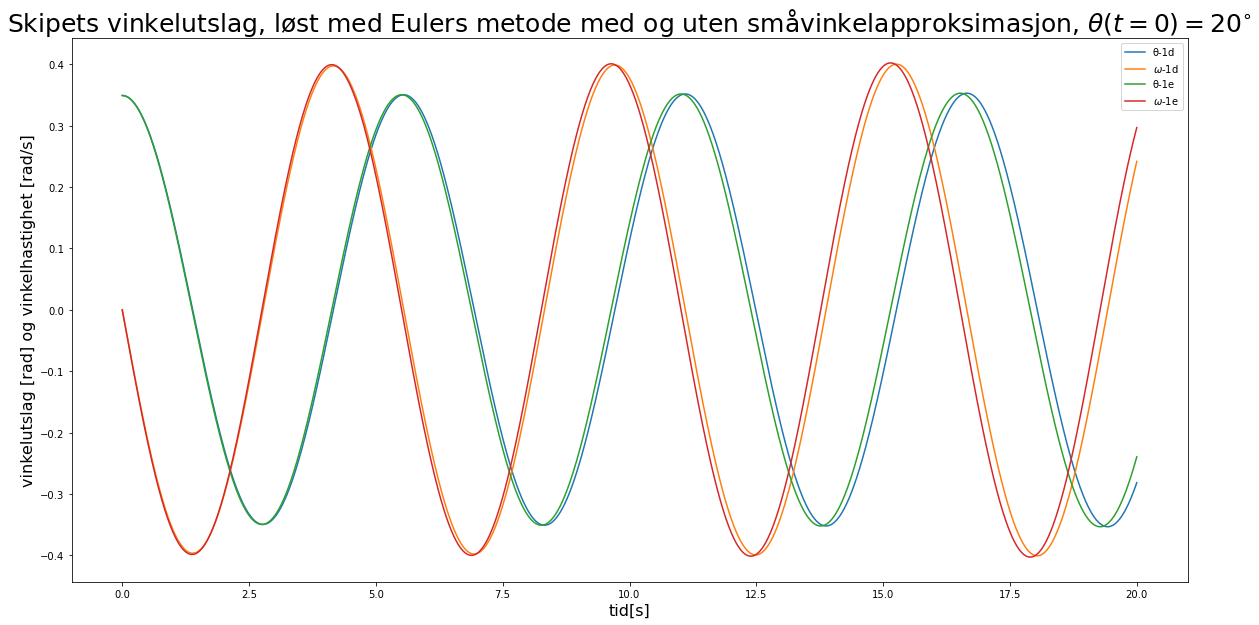

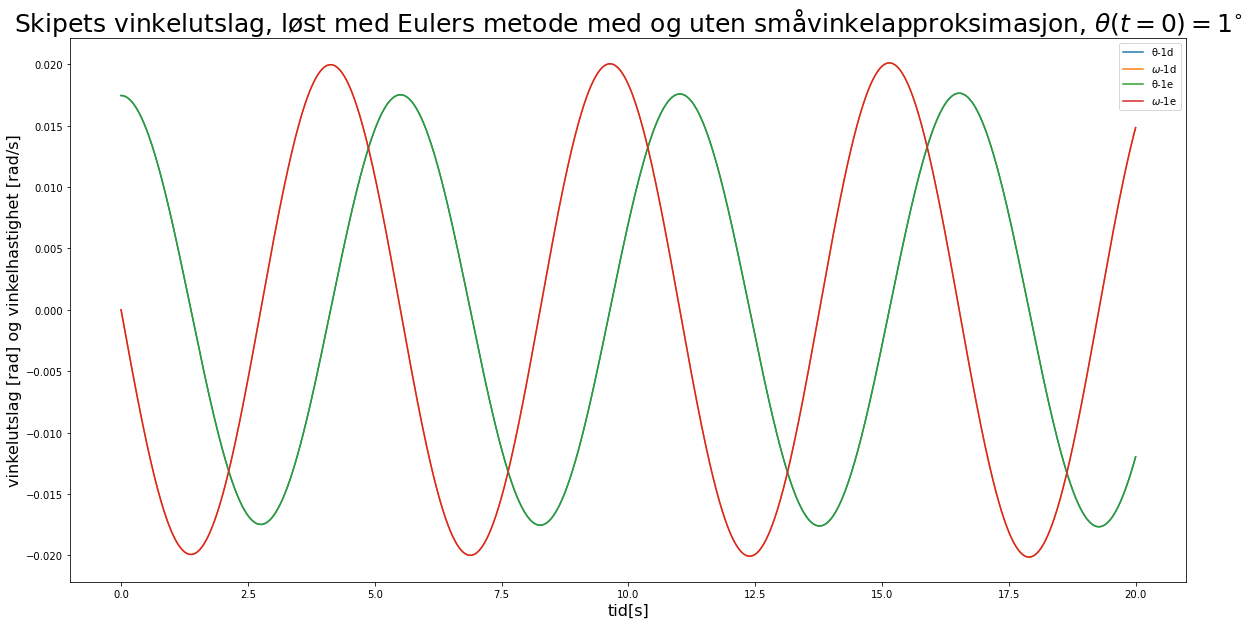

In [10]:
data_1e_20_grader = np.load('1e_20_grader.npz')
plt.figure(figsize = (20, 10))
plt.plot(data_1d['time'], data_1d['angles'], label = 'θ-1d')
plt.plot(data_1d['time'], data_1d['angular_velocity'], label = '$\omega$-1d')
plt.plot(data_1e_20_grader['time'], data_1e_20_grader['angles'], label = 'θ-1e')
plt.plot(data_1e_20_grader['time'], data_1e_20_grader['angular_velocity'], label = '$\omega$-1e')
plt.title('Skipets vinkelutslag, løst med Eulers metode med og uten småvinkelapproksimasjon, $θ(t=0)=20^{\circ}$', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag [rad] og vinkelhastighet [rad/s]', fontsize = 16)
plt.legend()
plt.show()

data_1e_1_grad = np.load('1e_1_grad.npz')
plt.figure(figsize = (20, 10))
plt.plot(data_1e_1_grad['time_1d'], data_1e_1_grad['angles_1d'], label = 'θ-1d')
plt.plot(data_1e_1_grad['time_1d'], data_1e_1_grad['angular_velocity_1d'], label = '$\omega$-1d')
plt.plot(data_1e_1_grad['time_1e'], data_1e_1_grad['angles_1e'], label = 'θ-1e')
plt.plot(data_1e_1_grad['time_1d'], data_1e_1_grad['angular_velocity_1e'], label = '$\omega$-1e')
plt.title('Skipets vinkelutslag, løst med Eulers metode med og uten småvinkelapproksimasjon, $θ(t=0)=1^{\circ}$', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag [rad] og vinkelhastighet [rad/s]', fontsize = 16)
plt.legend()
plt.show()

Det observeres en tydelig forskjell mellom plottene til hvilken grad løsningene, med og uten småvinkelapproksimasjonen $\sin\theta\approx\theta$, divergerer med økende verdi av $t$. En tommelfingelregel er at småvinkelapproksimasjonen er relativt god for vinkler opp til omtrent $10$ grader. Det er derfor rimelig at det fås divergerende løsninger over tid for en initialverdi $\theta_0=20^{\circ}$, mens løsningene omtrent sammenfaller for $\theta_0=1^{\circ}$.

Eulers metode ser ut til å gi et relativt rimelig resultat, da Newtons lov med de gitte betingelsene skal føre til en harmoniske variasjon av utslagsvinkelen og vinkelfrekvensen for skipets vugging. Ettersom  metoden er av orden 1, vil større steglengder føre til urimelige resultater. Det kan derfor lønne seg å utvikle en metode av høyere orden for fikspunktlikninger, så derfor implementeres 4.ordens Runge-Katta metoden (RK4) for å løse videre differentiallikninger. RK4-metoden er definert som følger:

$\displaystyle \vec{k}_1 = \vec{f}(t_i, \vec{w}_i)$

$\displaystyle \vec{k}_2 = \vec{f}\left(t_i+\frac{h}{2}, \vec{w}_i + \frac{h}{2}\vec{k}_1\right)$

$\displaystyle \vec{k}_3 = \vec{f}\left(t_i+\frac{h}{2}, \vec{w}_i + \frac{h}{2}\vec{k}_2\right)$

$\displaystyle \vec{k}_4 = \vec{f}\left(t_i+h, \vec{w}_i + h\vec{k}_3\right)$

$\displaystyle \vec{w}_{i+1} = \vec{w}_i + \frac{h}{6}\left(\vec{k}_1 + 2\vec{k}_2 + 2\vec{k}_3 + \vec{k}_4\right),$

der $h$ her betegner steglengden.

In [11]:
# Oppgave 1f)

def RK4(f, t, z, step_length):
    """
    parametere: f, likningssystemet vi ønsker å løse.
                t, tiden gitt i sekunder.
                z, array med løsningen på systemet.
                step_length, lengden på vært steg for en iterasjon.
    returnerer: neste tidssteg med tilhørende løsning.
    """
    k1 = f(t, z)
    k2 = f(t + 0.5*step_length, z + 0.5*step_length*k1)
    k3 = f(t + 0.5*step_length, z + 0.5*step_length*k2)
    k4 = f(t + step_length, z + step_length*k3)
    z_next = z + step_length*(k1 + 2*k2 + 2*k3 + k4)/6
    t_next = t + step_length
    return t_next, z_next

Benyttes RK4-metoden på samme intialverdiproblem som oppgave 1e), altså med startverdi $\theta_0=1$ oppnås følgende resultat.

In [12]:
z0_1f = [1*np.pi/180,0]
t_num_1f, z_num_1f, t_cap_1f, t_lost_1f = ode_solver(f_1e, t0, tend, z0_1f, step_length, RK4)

np.savez('1f', time = t_num_1f, angles = z_num_1f[:,0], angular_velocity = z_num_1f[:,1])


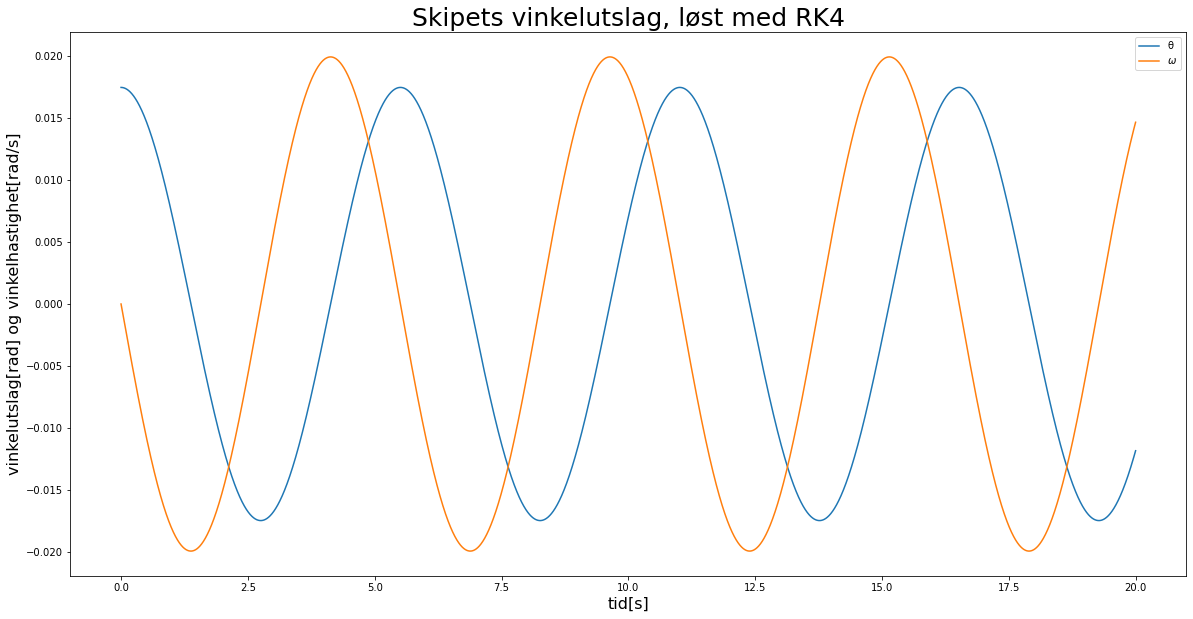

In [13]:
data_1f = np.load('1f.npz')
plt.figure(figsize = (20, 10))
plt.plot(data_1f['time'], data_1f['angles'], label='θ')
plt.plot(data_1f['time'], data_1f['angular_velocity'], label='$\omega$')
plt.title('Skipets vinkelutslag, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad] og vinkelhastighet[rad/s]', fontsize = 16)
plt.legend()
plt.show()

Dette likner svært mye på kurvene produsert av Eulers metode benyttet på samme problem. Det er som regel en god pekepinn på at plottene er riktige og breskriver systemet korrekt.

For å se hvor rimelig Eulers metode og RK4 er, sammenliknes de numeriske løsningene fra disse med den analytiske løsningen oppnådd av Newtons 2.lov for rotasjon om $C$, med antatt småvinkelapproksimasjonen:

$\displaystyle -mgh\theta = I_C\ddot{\theta} \quad \Rightarrow \quad I_C\ddot{\theta} + mgh\theta = 0 \quad \Rightarrow \quad \ddot{\theta} + \frac{mgh}{I_C}\theta=0 \quad \Rightarrow \quad \ddot{\theta}+\omega_0^2\theta=0.$ 

Dette gjenkjennes som likningen for en harmonisk oscillator med vinkelfrekvens $\omega_0=\sqrt{mgh/I_C}$. Denne likningen har løsningen:

$\displaystyle \tilde\theta(t)=A\cos(\omega_0t)+B\sin(\omega_0t)$

$\displaystyle \tilde\omega(t)=-\omega_0A\sin(\omega_0t)+\omega_0B\cos(\omega_0t)$

Løses for de ukjente konstantene ved å sette inn for initialverdiene $\tilde\theta(t=0)=0.01$ og $\tilde\omega(t=0)=0$:

$\displaystyle \tilde\omega(0)=-\omega_0A\sin(\omega_0\cdot 0)+\omega_0B\cos(\omega_0\cdot 0)=0$

$\displaystyle \Rightarrow \quad  \omega_0B=0 \quad \Rightarrow \quad B=0 \quad \Rightarrow \quad \tilde\theta(t)=A\cos(\omega_0t)$

$\displaystyle \tilde\theta(0)=A\cos(\omega_0\cdot0)=A=0.01 \quad \Rightarrow \quad \tilde\theta(t)=0.01\cos(\omega_0t).$

Løsningen for vinkelutslaget og vinkelfrekvensen er altså:

$\displaystyle \tilde\theta(t)=0.01\cos(\omega_0t)$

$\displaystyle \tilde\omega(t)=-0.01\omega_0\sin(\omega_0t).$

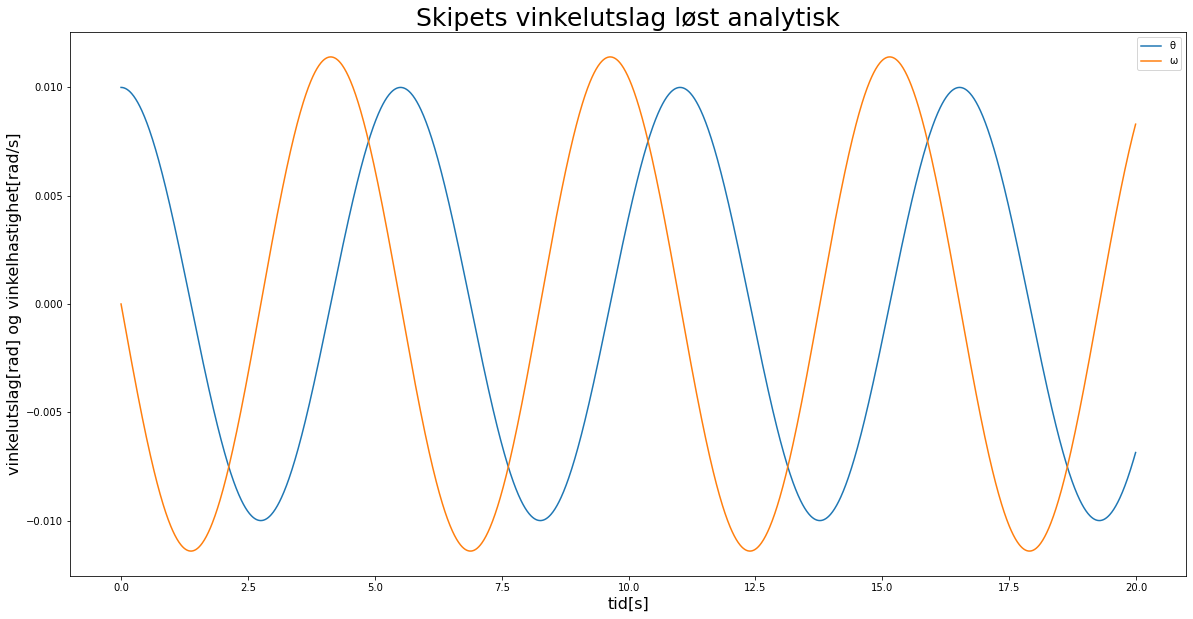

In [14]:
# Oppgave 1g)

def f_1g(step_length, z0):
    t = np.arange(0, 20, step_length)
    thetas = z0*np.cos(np.sqrt(m*g*h/I_C)*t)
    omegas = -np.sqrt(m*g*h/I_C)*z0*np.sin(np.sqrt(m*g*h/I_C)*t)
    return thetas, omegas, t

z0_1g = np.array([0.01, 0])
step_length = 0.01 #bør være så liten som mulig

theta_an_1g, omega_an_1g, t_an_1g = f_1g(step_length, z0_1g[0])

plt.figure(figsize = (20, 10))
plt.plot(t_an_1g, theta_an_1g, label = 'θ')
plt.plot(t_an_1g, omega_an_1g, label = 'ω')
plt.title('Skipets vinkelutslag løst analytisk', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad] og vinkelhastighet[rad/s]', fontsize = 16)
plt.legend()
plt.show()

En enda bedre pekepinn på at systemet er løst riktig, er å sammenligne med en eventuell analytisk løsning. Amplituden på kurven her er annerledes enn for løsningene laget med RK4 og Eulers metode. Perioden er derimot $T \approx 6$s både i den analytiske og de numeriske løsningene. Det observeres at vinkelhastigheten har en større amplitude (i verdi, uten enhet) enn vinkelutslaget, akkurat som i de numeriske løsningene på problemet. Alt dette tyder på at de numeriske løsningene er en god tilnærming for problemet, og at de er løst på en korrekt måte. Eventuelle forskjeller kommer tydeligere frem ved å se på differansen mellom den analytiske og hver av de numeriske løsningene. Dette er mer hensiktsmessig å gjøre i ett punkt. Det er både praktisk og strategisk å velge endepunktet, altså $t=20$, da eventuelle forskyvninger eller forskjell i periode vil ha god tid på å påvirke resultatene. For å undersøke steglengdens betydning på den numeriske feilen, plottes differansen mellom løsningene for hundre steglengder $h$ mellom 0.001 og 0.1s. For å sammenlikne metodene gjøres det en lineær regresjon av hver av feilsestimatene som funksjon av $h$.

In [15]:
# Oppgave 1h)

def get_last_values(h_steps, t0, tend, z0):
    euler_last_values, RK4_last_values, an_last_values = np.array([0,0]), np.array([0,0]), np.array([0,0])

    for h_step in h_steps:
        _, z_num_euler, _, _ = ode_solver(f_1e, t0, tend, z0, h_step, euler)
        _, z_num_RK4, _, _ = ode_solver(f_1e, t0, tend, z0, h_step, RK4)
        theta_an, omega_an, _ = f_1g(h_step, z0[0])
        euler_last_values = np.vstack((euler_last_values, z_num_euler[-1]))
        RK4_last_values = np.vstack((RK4_last_values, z_num_RK4[-1]))
        an_last_values = np.vstack((an_last_values, [theta_an[-1], omega_an[-1]]))
        #print(euler_last_values)

    return np.abs(euler_last_values[1::] - an_last_values[1::]), np.abs(RK4_last_values[1::] - an_last_values[1::])

In [16]:
h_steps = np.linspace(0.001, 0.1, 100)
z0_1h = np.array([0.01, 0])

euler_difference, RK4_difference = get_last_values(h_steps, t0, tend, z0_1h)

Euler: f(h)_euler = 0.181h + -0.002
RK4: f(h)_RK4 = 0.008h + -0.000


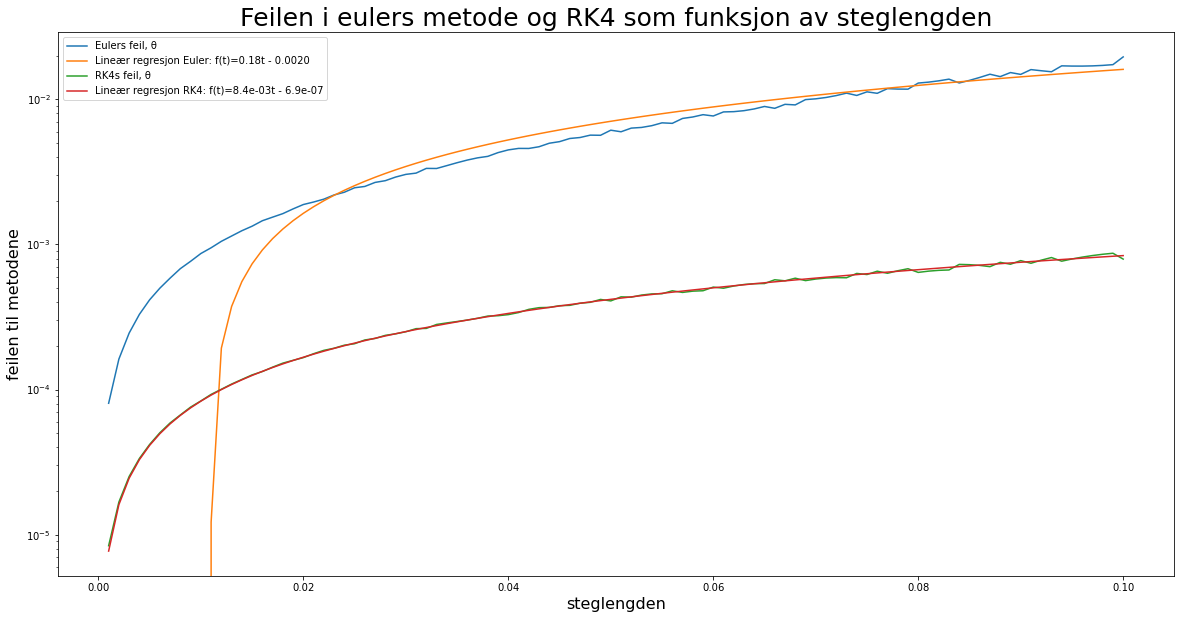

In [17]:
def f_difference(t,a,b):        #Gjetter på formen til funksjonen
    # return a*np.sqrt(b*t)+c
    return a*t+b
constants_euler, _ = curve_fit(f_difference, h_steps, euler_difference[:,0])
constants_RK4, _ = curve_fit(f_difference, h_steps, RK4_difference[:,0])
print(f'Euler: f(h)_euler = {constants_euler[0]:.3f}h + {constants_euler[1]:.3f}')
print(f'RK4: f(h)_RK4 = {constants_RK4[0]:.3f}h + {constants_RK4[1]:.3f}')

def f_euler(t):
    return constants_euler[0]*t + constants_euler[1]
    # return constants_euler[0]*np.sqrt(constants_euler[1]*t) #+ constants_euler[2]

def f_RK4(t):
    return constants_RK4[0]*t + constants_RK4[1]
    # return constants_RK4[0]*np.sqrt(constants_RK4[1]*t) #+ constants_RK4[2]

# print(f_euler(h_steps))
plt.figure(figsize = (20, 10))
plt.plot(h_steps, euler_difference[:,0], label = 'Eulers feil, θ') #, 'Eulers feil ω'])
plt.plot(h_steps, f_euler(h_steps), label='Lineær regresjon Euler: f(t)=0.18t - 0.0020')
plt.plot(h_steps, RK4_difference[:,0], label = 'RK4s feil, θ') #, 'RK4s feil ω'])
plt.plot(h_steps, f_RK4(h_steps), label='Lineær regresjon RK4: f(t)=8.4e-03t - 6.9e-07')
plt.title('Feilen i eulers metode og RK4 som funksjon av steglengden', fontsize = 25)
plt.xlabel('steglengden', fontsize = 16); plt.ylabel('feilen til metodene', fontsize = 16)
plt.yscale('log')
plt.legend()
plt.show()

I plottet har det blitt benyttet logaritmiske akser, for å tydeligere kunne se hvor endringen i steglengde bidrar minst til å øke feilen. Feilen øker imidlertid for økende steglengde, hos begge de numeriske metodene. Økningen er derimot størst hos Euler, som kan ses ved at stigningstallet til den lineære regresjonsmodellen er omtrent 22 ganger høyere enn for RK4. Dette er som forventet, da et økende antall funksjonsevalueringer vil resultere i minkende lokalfeil. Det kommer også tydelig frem fra plottet, og uttrykkene for de lineære regresjonene, at den 4.ordens Runge-Katta metoden, som utfører fire funksjonsevalueringer per steg, er betydelig mer nøyaktig enn Eulers metode, som kun utfører én. Av samme grunn vil RK4-metoden resultere i mindre lokalfeil enn Euler, og derfor benyttes RK4-metoden som differensialliknings-løser i resten av prosjektet. Omtrent ved steglengde $ h= 0.02$ begynner feilen å flate ut. Dette er fordi den prosentvise endringen i steglengden minker, jo større steglengden blir.

I resten av prosjektet vil vi bevege oss litt vekk fra de mange tilnærmelsene og forenklingene vi har gjort så langt, og introdusere andre krefter, bevegelser og faktorer som påvirker skipets dynamikk.

Vi starter med å la mengden fortrengt vann variere, der $A_0 \neq A = \frac{1}{2}R^2(\gamma-\sin\gamma)$. Massesenteret $C$ vil da ikke lenger ligge i ro, og skipets dynamikk vil beskrives ved de koblede likningene for Newtons 2.lov for translasjon av og rotasjon om $C$:

$\displaystyle \sum\vec{F}=m\vec{A}=m\frac{d\vec{V}}{dt}=m\frac{d^2\vec{R}}{dt^2}=m\frac{d^2}{dt^2}[x_C,y_C]$

$\displaystyle \sum\tau=I_C\frac{dw}{dt}$

På grunn av translasjon i både x- og y-retning av tyngdepunktet, oppdaterer vi nå vektoren av løsninger til å inneholde både vinkelutslag, vinkelhastighet, posisjonskoordinater og hastighetskoordinater:

$\displaystyle\vec{w}(t) = [\theta(t) \quad \omega(t) \quad x_C(t) \quad y_C(t) \quad v_{x,C}(t)\quad v_{y,C}(t)]^T$

Vi starter med å beskrive det koblede ODE-systemet i den situasjonen der dynamikken kun er bestemt av gravitasjons- og oppdriftskrefter, nå med $|F_B|=A\sigma_0g\neq|F_G|=mg=A_0\sigma_0g$. Da får vi ingen translasjon av C, og rotasjonsbevegelsen beskrives fullstendig av:

$\displaystyle\sum\tau = \tau_B = -F_Bh\sin\theta = -A\sigma_0gh\sin\theta = I_C\ddot{\theta} = I_C\frac{d\omega}{dt}$

$\displaystyle\Rightarrow\quad \frac{dw}{dt} = \frac{-A\sigma_0gh\sin\theta}{I_C} = \frac{-R^2(\gamma-\sin\gamma)\sigma_0gh\sin\theta}{2I_C}$

Sektorvinkelen $\gamma$ avhenger av rotert vinkel $\theta$, og oppfyller:

$\displaystyle \cos (\gamma/2) = y_M^\theta/R=[R\cos(\beta/2)-(4R/3\pi)(1-\cos\theta)+\Delta y_C]/R$
$=\cos(\beta/2)-(4/3\pi)(1-\cos\theta)+\Delta y_C/R$

$\displaystyle \Rightarrow \quad \gamma = 2 \arccos [\cos(\beta/2)-(4/3\pi)(1-\cos\theta)+\Delta y_C/R]$

$\displaystyle \vec{f}(t, \vec{w}) = \frac{d\vec{w}}{dt} = \left[\omega(t) \quad \frac{-R^2(\gamma(\theta)-\sin\gamma(\theta))\sigma_0gh\sin\theta(t)}{2I_C} \quad v_{x, C}(t) \quad v_{y,C}(t) \quad a_{x,C}(t) \quad a_{y,C}(t)\right]^T$

$\displaystyle a_{y,C}(t) = -\frac{mg-F_B}{m}\cos\theta = -\frac{mg-A\sigma_0g}{m}\cos\theta = g\left(\frac{A\sigma_0}m - 1\right)\cos\theta$

$\displaystyle a_{x,C}(t) = -\frac{mg-F_B}{m}\sin\theta = -\frac{mg-A\sigma_0g}{m}\sin\theta = g\left(\frac{A\sigma_0}m - 1\right)\sin\theta$ 

Da får vi at systemet kan beskrives som følger:

$\displaystyle \vec{f}(t, \vec{w}) = \frac{d\vec{w}}{dt} = \left[\omega(t) \quad \frac{-R^2(\gamma(\theta)-\sin\gamma(\theta))\sigma_0gh\sin\theta(t)}{2I_C} \quad v_{x, C}(t) \quad v_{y,C}(t) \quad g\left(\frac{R^2(\gamma(\theta)-\sin\gamma(\theta))\sigma_0}{2m} - 1\right)\sin\theta \quad g\left(\frac{R^2(\gamma(\theta)-\sin\gamma(\theta))\sigma_0}{2m} - 1\right)\cos\theta\right]^T$


In [18]:
# Oppgave 2a)
def gamma(theta, y_C, beta):
    return 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta)) + (y_C - y_C0(R, beta))/R)

def area_water(theta, y_C, beta=beta):
    return (1/2)*R**2*(gamma(theta, y_C - y_C0(R, beta), beta) - np.sin(gamma(theta, y_C - y_C0(R, beta), beta)))

def a_x(A, theta, y_C):
    return g*(A*mass_density_water/m - 1)*np.sin(theta)

def a_y(A, theta, y_C):
    return g*(A*mass_density_water/m - 1)*np.cos(theta)

def f_2a(t, z):
    dw = np.array([z[1], -area_water(z[0], z[3])*mass_density_water*g*h*np.sin(z[0])/I_C, 
                   z[4], z[5], a_x(area_water(z[0], z[3]), z[0], z[3]), a_y(area_water(z[0], z[3]), z[0], z[3])])
    return dw

Vi ser på nytt på hvordan vinkelutslaget og vinkelfrekvensen til skipets vugging vil variere over tid, men tar nå hensyn til at arealet av det fortrengte vannet vil endre seg som en funksjon av $\theta$. For å studere hvor stor effekten av variasjonen av mengden fortrengt vann er, plotter vi $y_C$ som funksjon av $t$.

In [19]:
# Oppgave 2b)

z0_2b = np.array([20*np.pi/180, 0, 0, y_C0(R, beta), 0, 0])
step_length = 0.01 #bør være så liten som mulig

t_num_2b, z_num_2b, t_cap_2b, t_lost_2b = ode_solver(f_2a, t0, tend, z0_2b, step_length, RK4)
np.savez('2b', time = t_num_2b, angles = z_num_2b[:,0], angular_velocity = z_num_2b[:,1], C_position_x = z_num_2b[:, 2], 
               C_position_y = z_num_2b[:, 3], C_velocity_x = z_num_2b[:, 4], C_velocity_y = z_num_2b[:, 5])

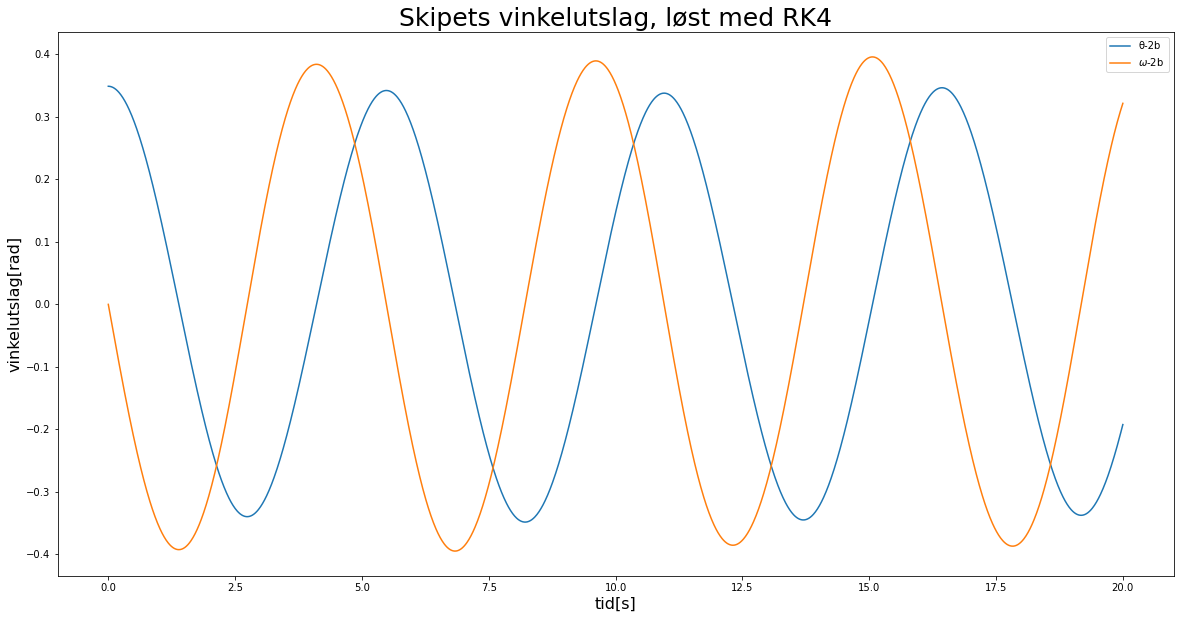

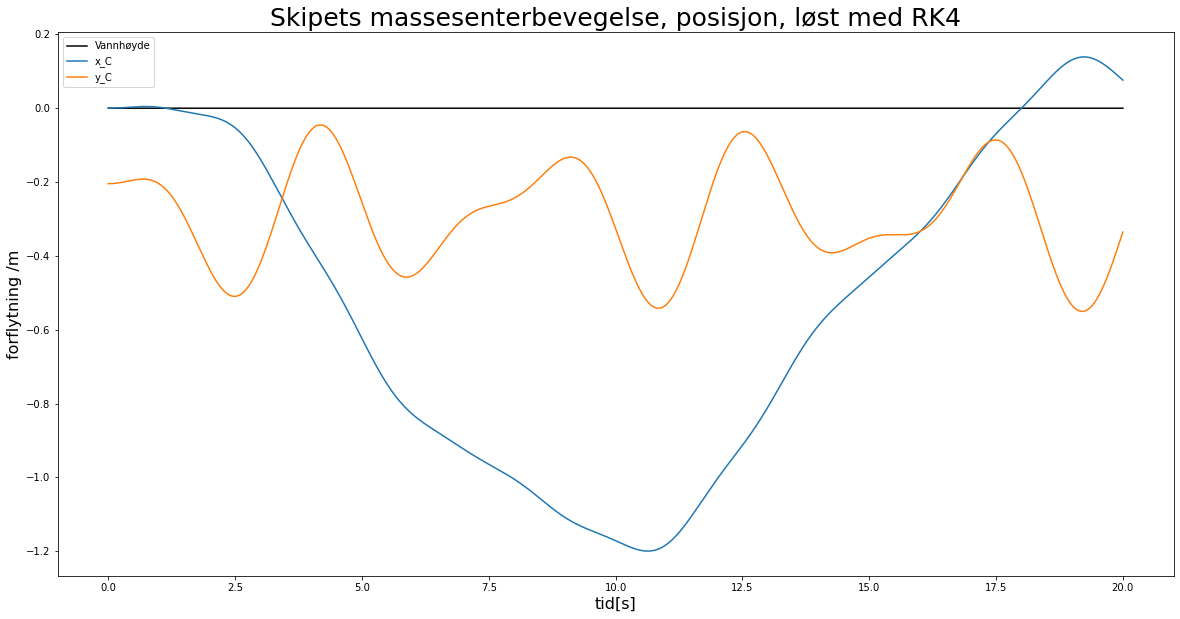

<ipython-input-20-da1197ab56a2>:26: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B8BFC310> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', 'v_x', 'v_y'])


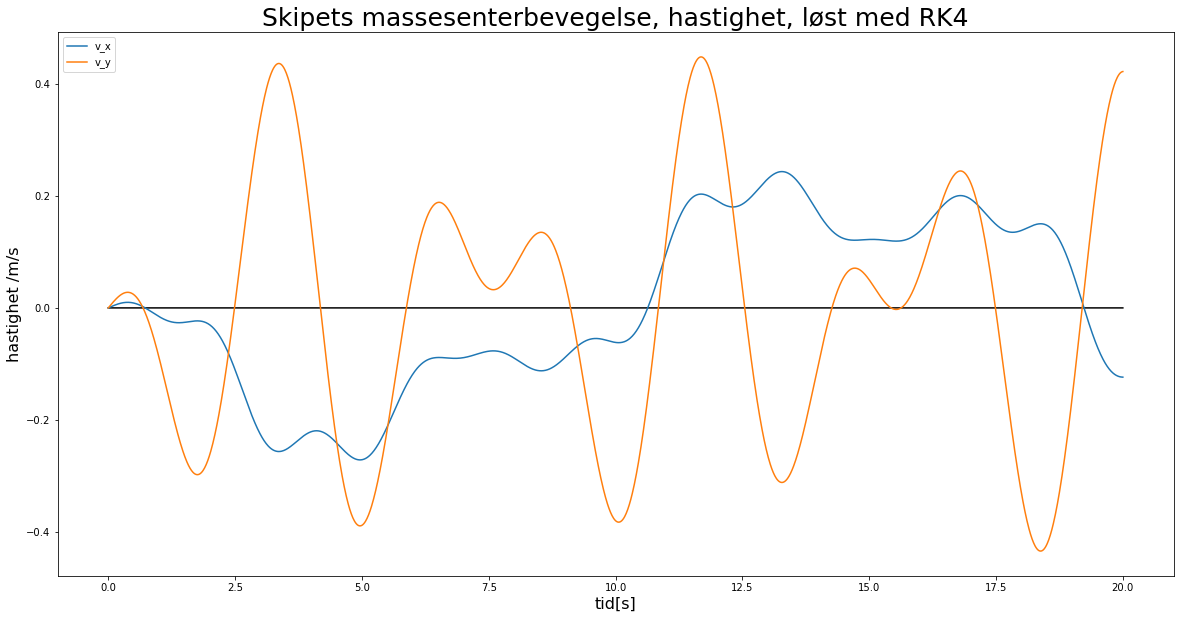

In [20]:
data_2b = np.load('2b.npz')

plt.figure(figsize = (20, 10))
plt.plot(data_2b['time'], data_2b['angles'])
plt.plot(data_2b['time'], data_2b['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ-2b', '$\omega$-2b'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2b['time'], np.full(len(data_2b['time']), 0), color = 'k')
plt.plot(data_2b['time'], data_2b['C_position_x'])
plt.plot(data_2b['time'], data_2b['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning /m', fontsize = 16)
plt.legend(['Vannhøyde', 'x_C', 'y_C'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2b['time'], np.full(len(data_2b['time']), 0), color = 'k')
plt.plot(data_2b['time'], data_2b['C_velocity_x'])
plt.plot(data_2b['time'], data_2b['C_velocity_y'])
plt.title('Skipets massesenterbevegelse, hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('hastighet /m/s', fontsize = 16)
plt.legend(['_', 'v_x', 'v_y'])
plt.show()

Det første som er enkelt å legge merke til er at vinkelutslaget og vinkelhastigheten ikke har endret seg fra tidligere. Det er (som nevnt tidligere i oppgaven) fordi det ikke er noen krefter som er en funksjon av hastigheten til pendelen, dermed er det ingen dempende effekt på pendelen. Heller er det ingen ytre pådrivende kraft som endrer svingeamplituden. Vi ser at massesenterets høyde varierer mellom en maksimal og minimal verdi, og skipet vil altså duppe opp og ned i vannet når vi tar hensyn til at mengden fortrengt vann kan variere. Ved å plotte massesenterets horisontale posisjon, observerer vi også at skipet vil bevege seg fra side til side. Da mengden fortrengt vann er varierende, og vi nå har et koblet system, vil ikke skipets vertikale bevegelse være fullstendig harmonisk, men vi observerer fortsatt en periodisk trend. 

Ved store utslagsvinkler, altså hvis skipet vugger for langt til den ene eller andre retningen, er det fare for at skipet kantrer. Vi definerer at skipet kantrer dersom dekket kommer i kontakt med vannet. Det lønner seg derfor å betegne skipets kant og dekkets laveste punkt som $K$, og skipet kantrer altså dersom $y_K\leq0$, når vannoverflaten er satt til å være ved $y=0$. Dette forekommer når $\displaystyle \theta > \frac{\pi-\gamma}{2}$. 

![figur](https://imgur.com/uVa7uIy.jpg)
**Figur 7:** Kantring av skipet ved utslagsvinkel $\theta$ stor nok

Hvis skipet kantrer ved $t = t_i$, setter vi alle komponentene av $\vec{w}(t)$, untatt $\theta$, lik 0 fra og med $t = t_i$. For alle $j > i$ setter vi $\displaystyle \theta(t = t_j) = \pm(\theta_{i-1})\frac{\pi}{2}$ for å vise tydelig at skipet kantrer. Vi ser på hva som skjer med $\theta(t=0)=0$ som initialverdi, og undersøker hvilken laveste initalverdi $\omega(t=0)$ som gir kantring.

In [21]:
# Oppgave 2c)

def check_capsize(theta, y_C, beta=beta):
    return np.abs(theta) > ((np.pi-gamma(theta, y_C, beta))/2)

def f_cap(t, z):
    if len(z)==8: dw = np.array([np.sign(z[0]*np.pi/2), 0, 0, 0, 0, 0, 0, 0])
    else: dw = np.array([np.sign(z[0]*np.pi/2), 0, 0, 0, 0, 0])
    return dw

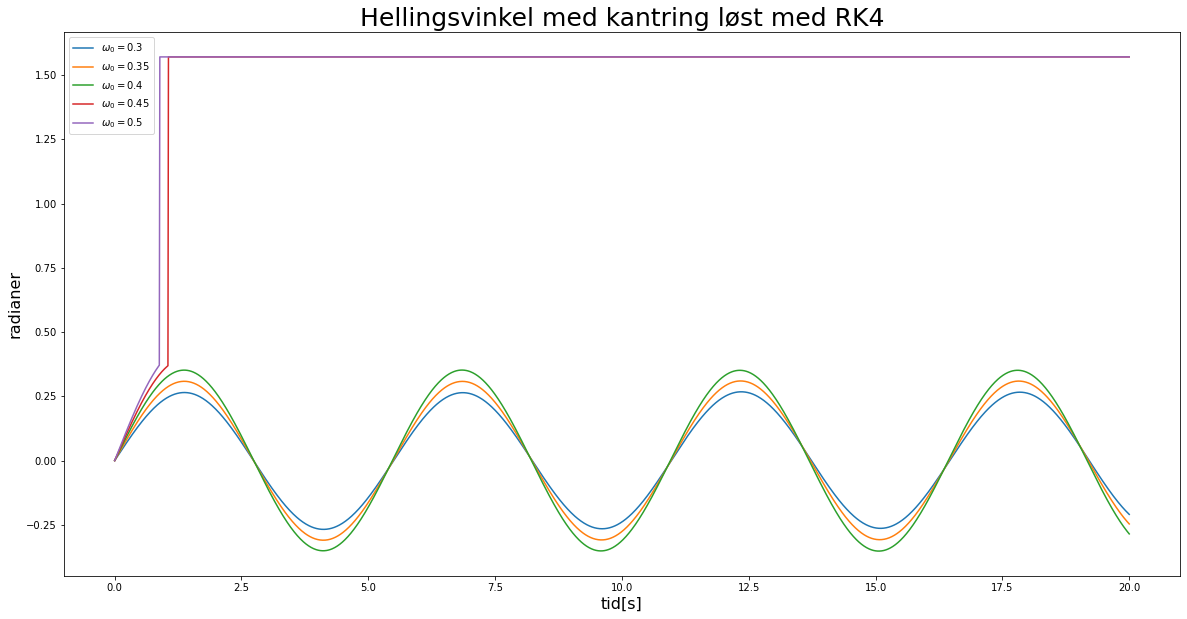

In [22]:
omega_array = np.linspace(0.3,0.5,5)
plt.figure(figsize = (20, 10))
for omega in omega_array:
    z0_2c = np.array([0*np.pi/180, omega, 0, y_C0(R, beta), 0, 0])
    t_num_2c, z_num_2c, t_cap_2c, t_lost_2c = ode_solver(f_2a, t0, tend, z0_2c, step_length, RK4, beta=beta, cap=True, cargo=False, fence=False)
# np.savez('2c', time = t_num_2c, angles = z_num_2c[:,0], angular_velocity = z_num_2c[:,1], 
#            C_position_x = z_num_2c[:, 2], C_position_y = z_num_2c
#            [:, 3], C_velocity_x = z_num_2c[:, 4], C_velocity_y = z_num_2c[:, 5])
    plt.plot(t_num_2c, z_num_2c[:,0])
plt.title('Hellingsvinkel med kantring løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('radianer', fontsize = 16)
plt.legend([f'$\omega_0={omega_array[0]}$', f'$\omega_0={omega_array[1]}$', f'$\omega_0={omega_array[2]}$',
            f'$\omega_0={omega_array[3]}$', f'$\omega_0={omega_array[4]}$'])
plt.show()

Figuren over viser at båten vil kantre når startvinkelen er null radianer og vinkelhastigheten ved start er over eller lik $\omega_0 \approx 0.45$ rad/s. Lavere initial-vinkelhastigheter vil ikke gi store nok utslag til at båten kantrer, gitt at vi kun ser på tyngdekraftens og oppdriftens bidrag ved en varierende mengde fortrengt vann.

Vi ønsker videre å undersøke effekten av å introdusere en ny faktor som inngår i skipets dynamikk, og antar nå at skipet har en bevegelig last med masse $m_L$. Vi behandler lasten som en punktpartikkel, antar at den ikke er festet, og forenkler fysikken ved å tillate friksjonsløs bevegelse av lasten på dekket. Punktmassen $m_L$ plasseres midt på dekk, og ligger altså i utgangspunktet i ro i posisjon M, der bevegelse av lasten grunnet vugging vil resultere i en rikere dynamikk og vil kunne påvirke skipets stabilitetsegenskaper. Lastens masse og posisjon defineres relativt til skipets masse og midtpunkt helholdsvis, altså $m_L=k\cdot m$ og $s_L \in [-R,R]$. Lastens hastighet defineres som $\displaystyle v_L = \frac {ds_L}{dt}$.

Bevegelsen til lasten vil under disse antakelsene kunne beskrives av tyngdekraften på lasten og normalkraften $\bf{N}$ fra dekket, samt lastens komplementære normalkraft $-\bf{N}$ på skipet som resulterer i et dreiemoment $\tau_L$.

Tyngdekraften $\displaystyle G = -m_Lg$ kan dekomponeres til $\displaystyle G_n = -m_Lg\cos\theta$ og $\displaystyle G_p = -m_Lg\sin\theta$, som i henhold til vårt koordinatsystem resulterer i:

$\displaystyle F_L^y = -m_Lg\cos^2\theta$

$\displaystyle F_L^x = m_Lg\cos\theta\sin\theta$

$\displaystyle \tau_L = \vec{r} \times \vec{F} = s_L \cdot G_n = -m_Lg\cos\theta s_L$

Lasten vil selv ha en akselerasjon:

$\displaystyle G_p = m_La_L \quad \Rightarrow \quad a_L = -g\sin\theta$

![figur](https://imgur.com/jcq57AL.jpg)
**Figur 8:** Krefter på bevegelig last og dreiemoment fra lastens kraft på skipet 

Lastens egne dynamikk styres altså kun av $\theta$, men den vil påvirke skipets dynamikk ved å øke systemets totalmasse, bidra med et ekstra ledd til dreiemomentet, og utsette skipet for ekstra krefter.

$\displaystyle \sum\tau = \tau_B + \tau_L = -F_Bh\sin\theta - m_Lg\cos\theta s_L = -g(A\sigma_0h\sin\theta+m_L\cos\theta s_L) = I_C\frac{dw}{dt}$

$\displaystyle \Rightarrow \quad \frac{dw}{dt} = \frac{-g(A\sigma_0h\sin\theta+m_L\cos\theta s_L)}{I_C}$

$\displaystyle \sum\vec{F}= F_G + F_B + F_L^y + F_L^x = m_Lg\cos\theta\sin\theta\hat{x} + (A\sigma_0g-m_Lg\cos^2\theta-m_{tot}g)\hat{y} = m_{tot}\vec{a}_C$

$\displaystyle \Rightarrow \quad a_{x,C} = \frac{m_L}{m_{tot}}g\cos\theta\sin\theta$

$\displaystyle \quad \quad a_{y,C} = \frac{1}{m_{tot}}A\sigma_0g-\frac{m_L}{m_{tot}}g\cos^2\theta-g$

Vi beregner først likevektsstørrelsene for $\beta$, $A_0$, $y^0$, etc... på nytt, nå med $m_{tot}=m+m_L$.

In [23]:
# Oppdaterte parametre

mass_cargo = np.array([0.001*m, 0.08*m, 0])
m_tot = m + mass_cargo  #([0], m+mass_cargo[1]])
mass_density_tot = np.array([mass_density_ship*(1 + 0.001), mass_density_ship*(1 + 0.08), mass_density_ship])
I_C_2 = (1/2)*m_tot*(R**2)*(1 - 32/(9*np.pi**2))
A_0 = mass_density_tot*np.pi*R**2/(2*mass_density_water)


In [24]:
# Oppgave 2d)

mass_density_ship = mass_density_tot
beta02 = np.array([1.5, 1.5, 1.5])             # Starting value
beta_array, nit2 = newton(f_beta, df_beta, beta02, tol=1.e-18, max_iter=15)  # Apply Newton
beta001, beta08, beta = beta_array

print(f"Sektorvinkelen av skipets kontaktflate med vann i likevekt med m_L = 0.001m_L:")
print(f"\tbeta = {(beta001*180/np.pi):.2f} \n\tnumber of iterations = {nit2:d}")
print(f'y_M0: {y_M0(R, beta001):.2f} m \ny_C0: {y_C0(R, beta_array[0]):.2f} m \ny_B0: {y_B0(R, beta_array[0]):.2f} m \ny_D0: {y_D0(R, beta_array[0]):.2f} m')

print(f"\nSektorvinkelen av skipets kontaktflate med vann i likevekt med m_L = 0.08m_L:")
print(f"\tbeta = {(beta08*180/np.pi):.2f} \n\tnumber of iterations = {nit2:d}")
print(f'y_M0: {y_M0(R, beta08):.2f} m \ny_C0: {y_C0(R, beta_array[1]):.2f} m \ny_B0: {y_B0(R, beta_array[1]):.2f} m \ny_D0: {y_D0(R, beta_array[1]):.2f} m')

Sektorvinkelen av skipets kontaktflate med vann i likevekt med m_L = 0.001m_L:
	beta = 132.40 
	number of iterations = 15
y_M0: 4.04 m 
y_C0: -0.21 m 
y_B0: -2.46 m 
y_D0: -5.96 m

Sektorvinkelen av skipets kontaktflate med vann i likevekt med m_L = 0.08m_L:
	beta = 136.58 
	number of iterations = 15
y_M0: 3.70 m 
y_C0: -0.55 m 
y_B0: -2.60 m 
y_D0: -6.30 m


Vi studerer så lastens bidrag til krefter og dreiemoment ved å plotte utslagsvinkelen på nytt, nå med:

$\displaystyle\vec{w}(t) = [\theta(t) \quad \omega(t) \quad x_C(t) \quad y_C(t) \quad v_{x,C}(t)\quad v_{y,C}(t) \quad s_L(t) \quad v_L(t)]^T$

$\displaystyle \vec{f}(t, \vec{w}) = \frac{d\vec{w}}{dt} = \left[\omega(t) \quad \frac{d\omega}{dt}(t) \quad v_{x, C}(t) \quad v_{y,C}(t) \quad a_{x,C}(t) \quad a_{y,C}(t) \quad v_L(t) \quad a_L(t)\right]^T$

$\displaystyle = \left[\omega(t) \quad \frac{-g(A\sigma_0h\sin\theta(t)+m_L\cos\theta(t) s_L)}{I_C} \quad v_{x, C}(t) \quad v_{y,C}(t) \quad \frac{m_L}{m_{tot}}g\cos\theta(t)\sin\theta(t) \quad \frac{1}{m_{tot}}A\sigma_0g-\frac{m_L}{m_{tot}}g\cos^2\theta(t)-g \quad v_L(t) \quad -g\sin\theta(t)\right]^T$

Dersom $|s_L(t)| > R$ faller lasten av skipet, og vi setter $m_L$ lik 0 kg, slik at lasten ikke
påvirker dynamikken til skipet etter at den faller av. Vi plotter så $\theta$ og $s_L$ som funksjon av tid for $m_L = 0.001m$ og $m_L = 0.08m$ fra $t = 0$ til $t = 40$, og markerer hvor lasten faller av, med initialbetingelser $\theta(t = 0) = 0$, $\omega(t = 0) = 0.2$, og lasten starter i ro ved $s_L(t = 0) = 3$ m.

In [25]:
def f_lost(t, z):
    dw = np.array([z[1], -area_water(z[0], z[3], beta_array[index])*mass_density_water*g*h*np.sin(z[0])/I_C_2[index], 
                   z[4], z[5], a_x(area_water(z[0], z[3], beta_array[index]), z[0], z[3]), 
                   a_y(area_water(z[0], z[3], beta_array[index]), z[0], z[3]), 0, 0])
    return dw

def f_2d(t, z):
    dw = np.array([z[1], -g*(area_water(z[0], z[3], beta_array[index])*mass_density_water*h*
                    np.sin(z[0])+mass_cargo[index]*np.cos(z[0])*z[6])/I_C_2[index],
                    z[4], z[5], mass_cargo[index]*g*np.cos(z[0])*np.sin(z[0])/m_tot[index],
                    area_water(z[0], z[3], beta_array[index])*mass_density_water*g/m_tot[index]
                    -mass_cargo[index]*g*np.cos(z[0])**2/m_tot[index]-g,
                    z[7], -g*np.sin(z[0])])
    return dw

In [26]:
t0, tend = 0, 40
step_length = 0.01 #bør være så liten som mulig

# m_L = 0.001*m -> index 0
index = 0

z0_2d_0 = np.array([0, 0.2, 0, y_C0(R, beta_array[index]), 0, 0, 3, 0])

t_num_2d_0, z_num_2d_0, t_cap_2d_0, t_lost_2d_0 = ode_solver(f_2d, t0, tend, z0_2d_0, step_length, RK4, beta_array[index], cap=True, cargo=True, fence=False)
np.savez('2d_0', time = t_num_2d_0, angles = z_num_2d_0[:,0], angular_velocity = z_num_2d_0[:,1], 
        C_position_x = z_num_2d_0[:, 2], C_position_y = z_num_2d_0[:, 3], 
        C_velocity_x = z_num_2d_0[:, 4], C_velocity_y = z_num_2d_0[:, 5],
        cargo_position = z_num_2d_0[:, 6], cargo_velocity = z_num_2d_0[:, 7],
        time_cap = t_cap_2d_0, time_lost = t_lost_2d_0)

# m_L = 0.08*m -> index 1
index = 1
z0_2d_1 = np.array([0, 0.2, 0, y_C0(R, beta_array[index]), 0, 0, 3, 0])

t_num_2d_1, z_num_2d_1, t_cap_2d_1, t_lost_2d_1 = ode_solver(f_2d, t0, tend, z0_2d_1, step_length, RK4, beta_array[index], cap=True, cargo=True, fence=False)
np.savez('2d_1', time = t_num_2d_1, angles = z_num_2d_1[:,0], angular_velocity = z_num_2d_1[:,1], 
        C_position_x = z_num_2d_1[:, 2], C_position_y = z_num_2d_1[:, 3], 
        C_velocity_x = z_num_2d_1[:, 4], C_velocity_y = z_num_2d_1[:, 5],
        cargo_position = z_num_2d_1[:, 6], cargo_velocity = z_num_2d_1[:, 7],
        time_cap = t_cap_2d_1, time_lost = t_lost_2d_1)

Lasten falt av ved t = 8.66 s


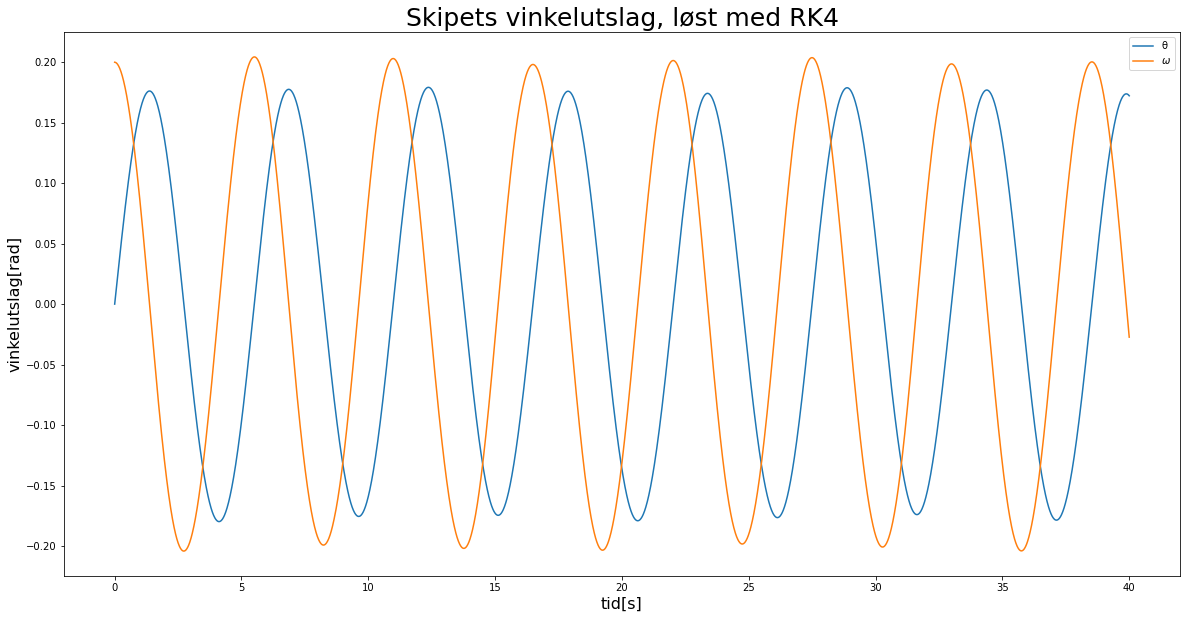

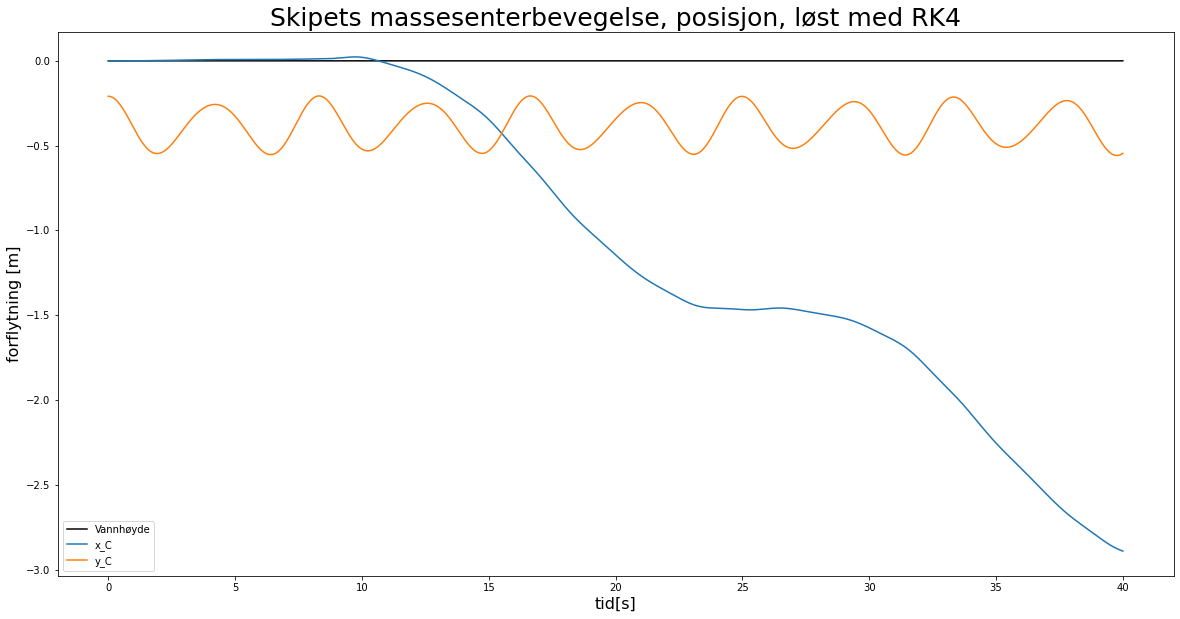

<ipython-input-27-f76300fded94>:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B68F86D0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', 'v_x', 'v_y'])


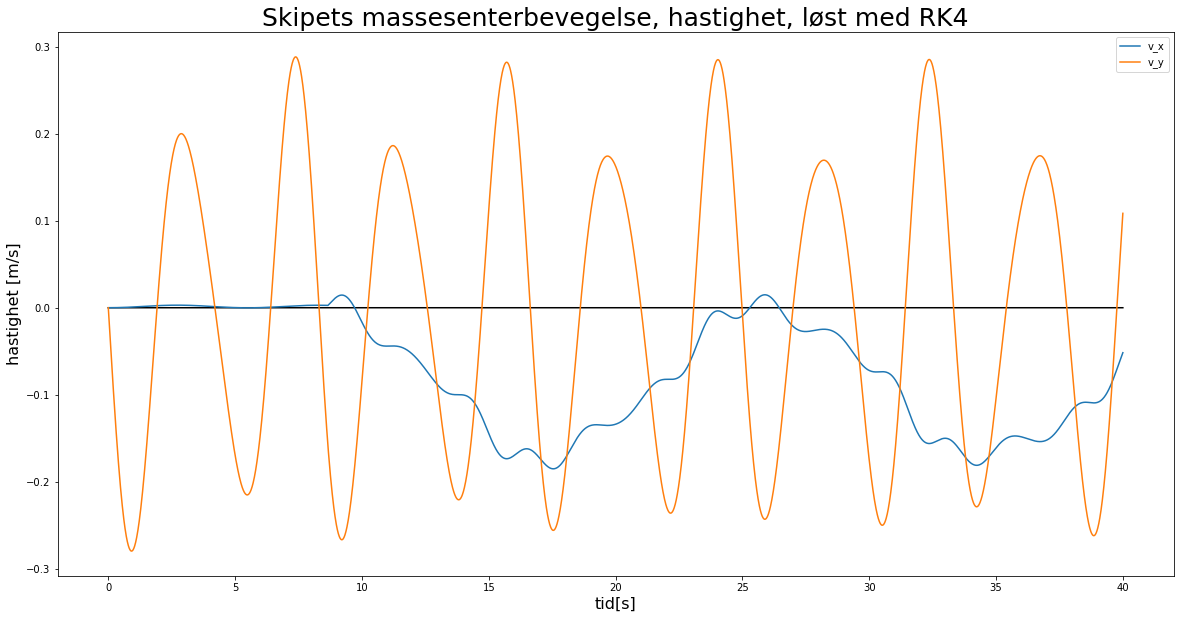

<ipython-input-27-f76300fded94>:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B74EF130> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$s_L$', '$v_L$'])


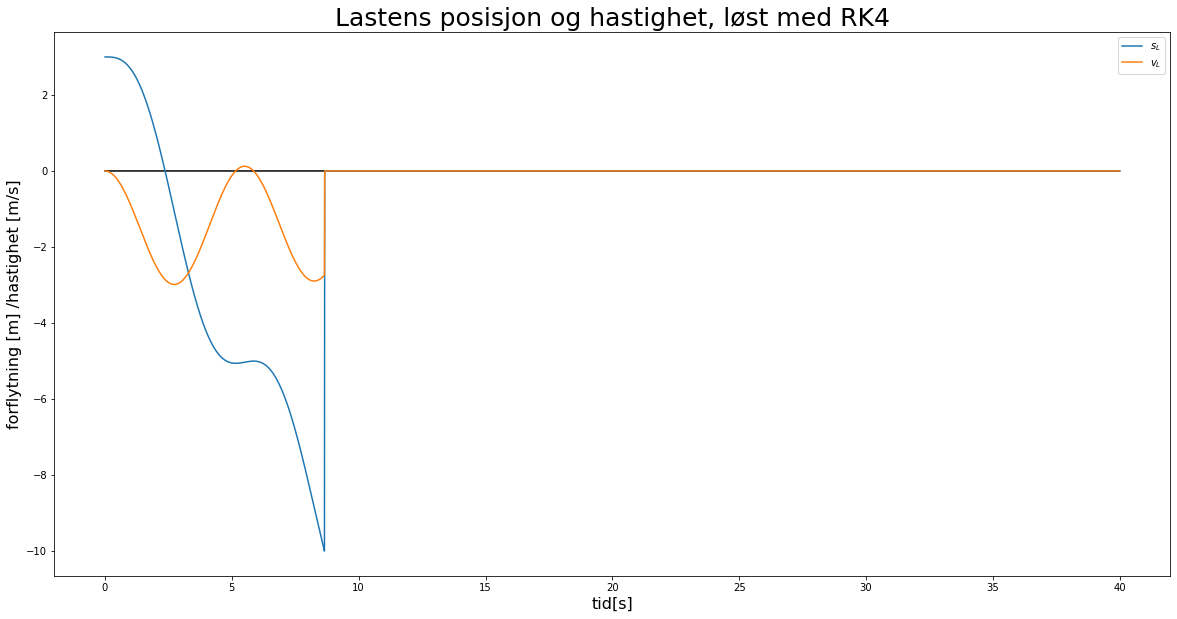

In [27]:
data_2d_0 = np.load('2d_0.npz')

if data_2d_0['time_lost']!=(-1): print(f"Lasten falt av ved t = {data_2d_0['time_lost']:.2f} s")
if data_2d_0['time_cap']!=(-1): print(f"Skipet kantret ved t = {data_2d_0['time_cap']:.2f} s")

plt.figure(figsize = (20, 10))
plt.plot(data_2d_0['time'], data_2d_0['angles'])
plt.plot(data_2d_0['time'], data_2d_0['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ', '$\omega$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2d_0['time'], np.full(len(data_2d_0['time']), 0), color = 'k')
plt.plot(data_2d_0['time'], data_2d_0['C_position_x'])
plt.plot(data_2d_0['time'], data_2d_0['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m]', fontsize = 16)
plt.legend(['Vannhøyde', 'x_C', 'y_C'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2d_0['time'], np.full(len(data_2d_0['time']), 0), color = 'k')
plt.plot(data_2d_0['time'], data_2d_0['C_velocity_x'])
plt.plot(data_2d_0['time'], data_2d_0['C_velocity_y'])
plt.title('Skipets massesenterbevegelse, hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('hastighet [m/s]', fontsize = 16)
plt.legend(['_', 'v_x', 'v_y'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2d_0['time'], np.full(len(data_2d_0['time']), 0), color = 'k')
plt.plot(data_2d_0['time'], data_2d_0['cargo_position'])
plt.plot(data_2d_0['time'], data_2d_0['cargo_velocity'])
plt.title('Lastens posisjon og hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m] /hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$s_L$', '$v_L$'])
plt.show()

For en last med masse $m_L=0.001m$ i forhold til skipets totalmasse, vil lasten med de gitte initialbetingelsene falle av skipet etter $t=8.66$ sekunder. Vi ser ikke en betydelig endring av skipets vinkelutslag før og etter lasten, dette er fordi vektapå lasten er mye lavere enn skipets egen vekt. Derimot, plottet for massesenterets posisjon og hastighet visualiserer tydeligere hvordan dynamikken til skipet påvirkes av lasten. Hastigheten til båten i y-retning endrer seg nesten ikke, mens hastigheten i x-retning drastisk øker i absoluttverdi når lasten faller av. Dette er fordi lastens hastighet går imort skipets hastighet, så i starten er det mer stabilt, men når lasten faller av kan skipet bevege seg mer fritt langs x-aksen.

Skipet kantret ved t = 10.58 s


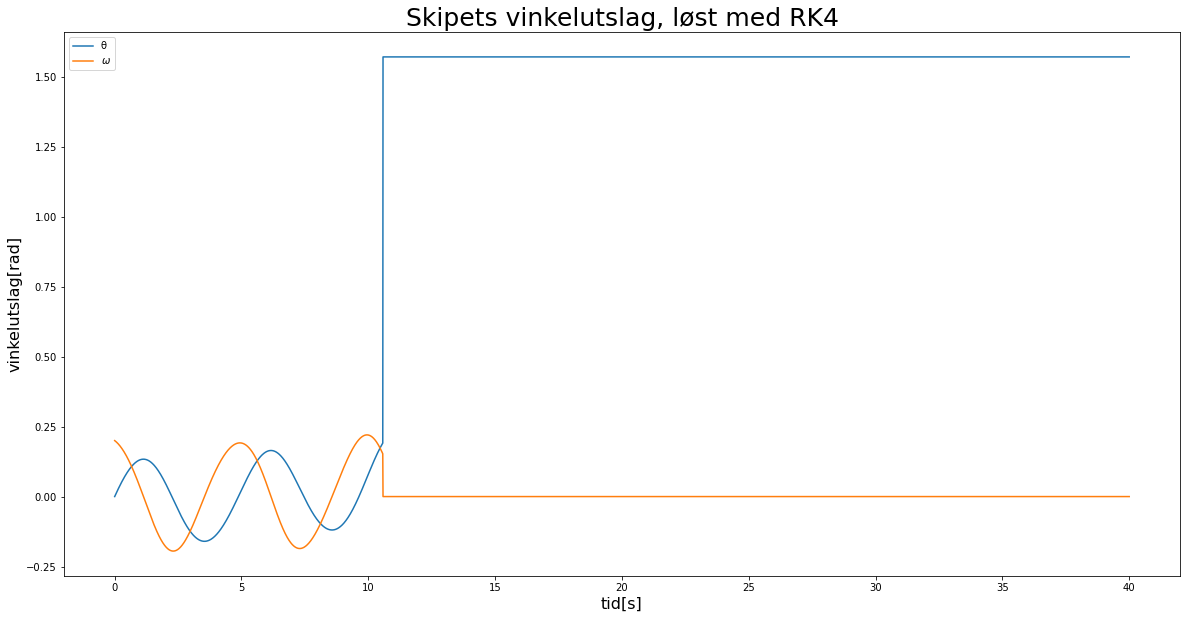

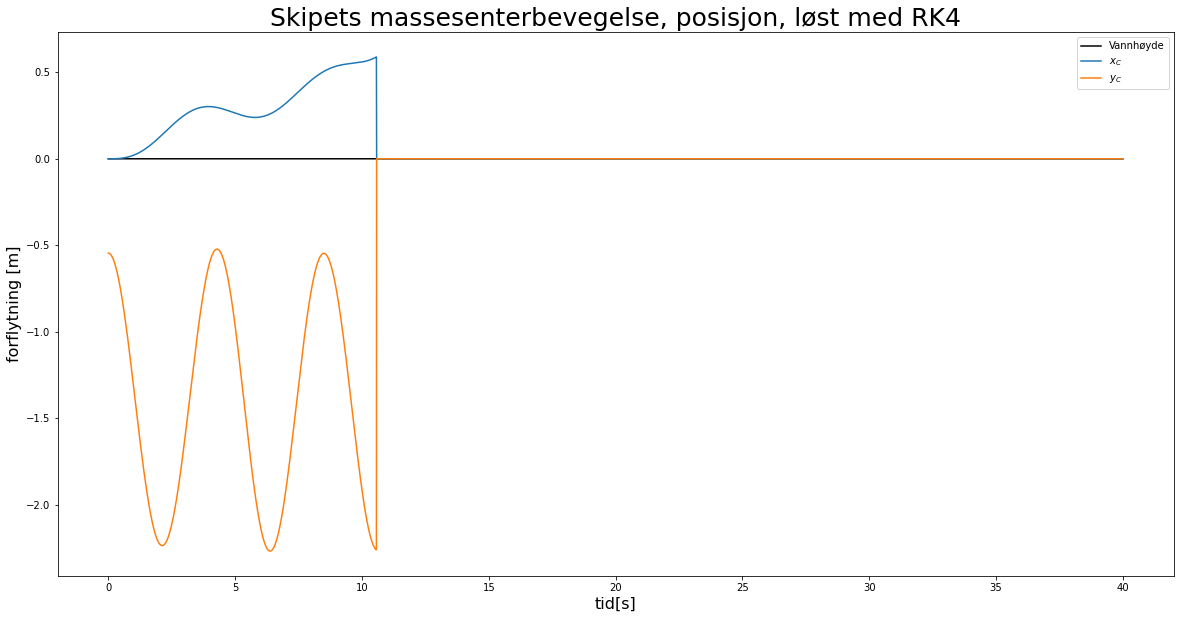

<ipython-input-28-9d13faf4d410>:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B74FDDC0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$v_x$', '$v_y$'])


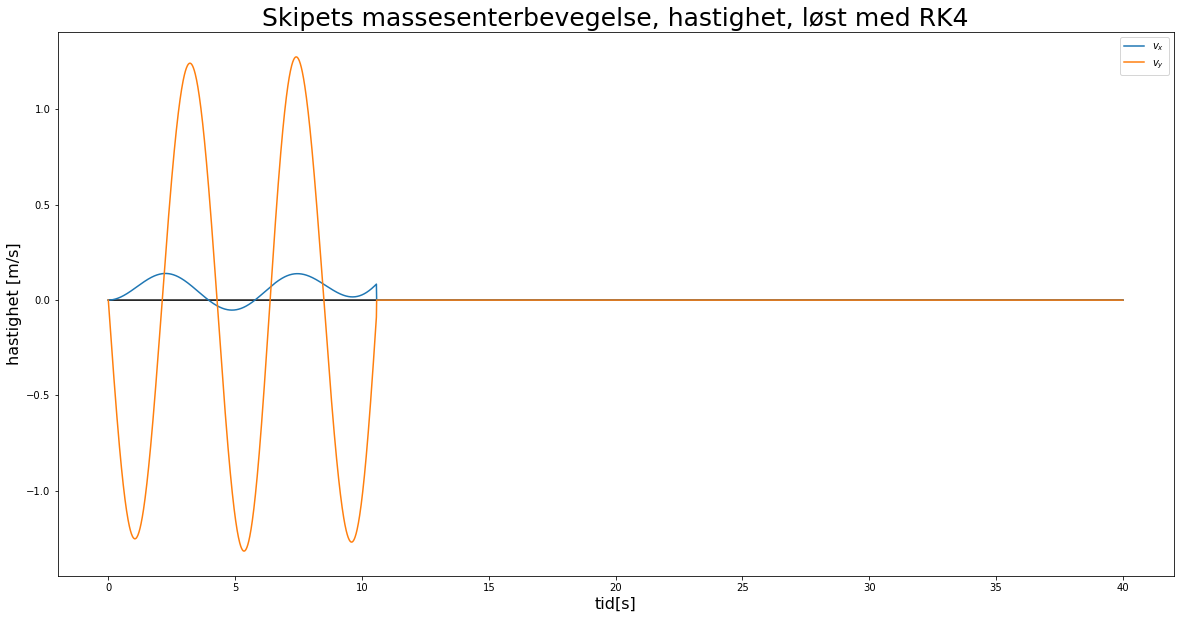

<ipython-input-28-9d13faf4d410>:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B8C1F190> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$s_L$', '$v_L$'])


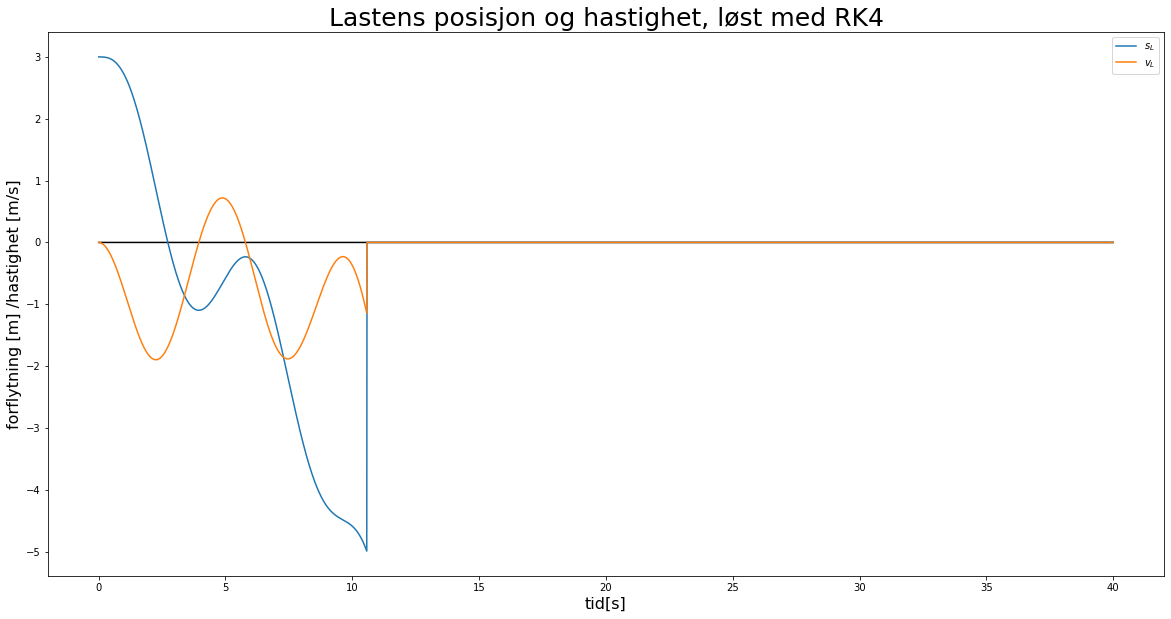

In [28]:
data_2d_1 = np.load('2d_1.npz')

if data_2d_1['time_lost']!=(-1): print(f"Lasten falt av ved t = {data_2d_1['time_lost']:.2f} s")
if data_2d_1['time_cap']!=(-1): print(f"Skipet kantret ved t = {data_2d_1['time_cap']:.2f} s")

plt.figure(figsize = (20, 10))
plt.plot(data_2d_1['time'], data_2d_1['angles'])
plt.plot(data_2d_1['time'], data_2d_1['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ', '$\omega$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2d_1['time'], np.full(len(data_2d_1['time']), 0), color = 'k')
plt.plot(data_2d_1['time'], data_2d_1['C_position_x'])
plt.plot(data_2d_1['time'], data_2d_1['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m]', fontsize = 16)
plt.legend(['Vannhøyde', '$x_C$', '$y_C$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2d_1['time'], np.full(len(data_2d_1['time']), 0), color = 'k')
plt.plot(data_2d_1['time'], data_2d_1['C_velocity_x'])
plt.plot(data_2d_1['time'], data_2d_1['C_velocity_y'])
plt.title('Skipets massesenterbevegelse, hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$v_x$', '$v_y$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2d_1['time'], np.full(len(data_2d_1['time']), 0), color = 'k')
plt.plot(data_2d_1['time'], data_2d_1['cargo_position'])
plt.plot(data_2d_1['time'], data_2d_1['cargo_velocity'])
plt.title('Lastens posisjon og hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m] /hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$s_L$', '$v_L$'])
plt.show()

For en last med masse $m_L=0.08m$ i forhold til skipets totalmasse, vil lastens påvirkning føre til en utslagsvinkel stor nok til at skipet kantrer etter $t=10.58$ sekunder. Vi ser at vinkelutslagene også blir noe større før dette punktet, da lasten er noe tyngre og vil "dytte" skipet lengre ut av likevektsposisjonen. Før kantringen ser man at vinkelutslaget og vinkelhastigheten har samme harmoniske natur som tidligere. Vi kan også se at hastightene i x- og y-retning er mer periodiske enn når lasten var lettere, eller det ikke var noen last i det hele tatt.

For å realisere skipsmodellen vår en smule, lar vi skipet vårt ha gjerder på hver av kantene til dekket. Gjerdene implementeres ved at dersom $|s_L| > R$ vil lasten ikke falle av, men istedet miste all fart og forbli på kanten. Vi neglisjerer kraften som overføres fra lasten til gjerdet for enkelhets skyld. Vi gjentar forrige oppgave med inkludering av gjerder, og plotter utviklingen av størrelsene vi ser er av interesse.

In [29]:
# Oppgave 2e)

def f_lost_fence(t, z):
    dw = np.array([z[1], -g*(area_water(z[0], z[3],beta_array[index])*mass_density_water*h*np.sin(z[0])+mass_cargo[index]*np.cos(z[0])*z[6])/I_C_2[index], 
                    z[4], z[5], mass_cargo[index]*g*np.cos(z[0])*np.sin(z[0])/m_tot[index], 
                    area_water(z[0], z[3], beta_array[index])*mass_density_water*g/m_tot[index]-mass_cargo[index]*g*np.cos(z[0])**2/m_tot[index]-g,
                    0, -g*np.sin(z[0])])
    return dw

# m_L = 0.001*m -> index 0
index = 0
t_num_2e_0, z_num_2e_0, t_cap_2e_0, t_lost_2e_0 = ode_solver(f_2d, t0, tend, z0_2d_0, step_length, RK4, beta=beta_array[index], cap=True, cargo=True, fence=True)
np.savez('2e_0', time = t_num_2e_0, angles = z_num_2e_0[:,0], angular_velocity = z_num_2e_0[:,1], 
        C_position_x = z_num_2e_0[:, 2], C_position_y = z_num_2e_0[:, 3], 
        C_velocity_x = z_num_2e_0[:, 4], C_velocity_y = z_num_2e_0[:, 5],
        cargo_position = z_num_2e_0[:, 6], cargo_velocity = z_num_2e_0[:, 7],
        time_cap = t_cap_2e_0, time_lost = t_lost_2e_0)

# m_L = 0.08*m -> index 1
index = 1
t_num_2e_1, z_num_2e_1, t_cap_2e_1, t_lost_2e_1 = ode_solver(f_2d, t0, tend, z0_2d_1, step_length, RK4, beta=beta_array[index], cap=True, cargo=True, fence=True)
np.savez('2e_1', time = t_num_2e_1, angles = z_num_2e_1[:,0], angular_velocity = z_num_2e_1[:,1], 
        C_position_x = z_num_2e_1[:, 2], C_position_y = z_num_2e_1[:, 3], 
        C_velocity_x = z_num_2e_1[:, 4], C_velocity_y = z_num_2e_1[:, 5],
        cargo_position = z_num_2e_1[:, 6], cargo_velocity = z_num_2e_1[:, 7],
        time_cap = t_cap_2e_1, time_lost = t_lost_2e_1)


Lasten traff gjerdet ved t = 8.66 s


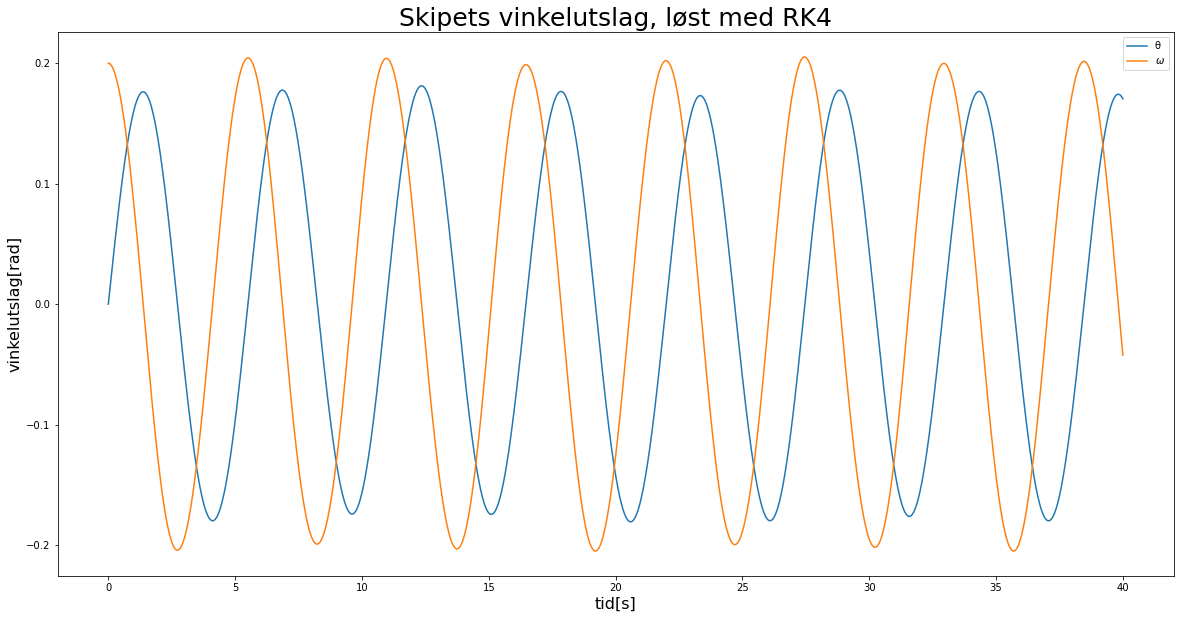

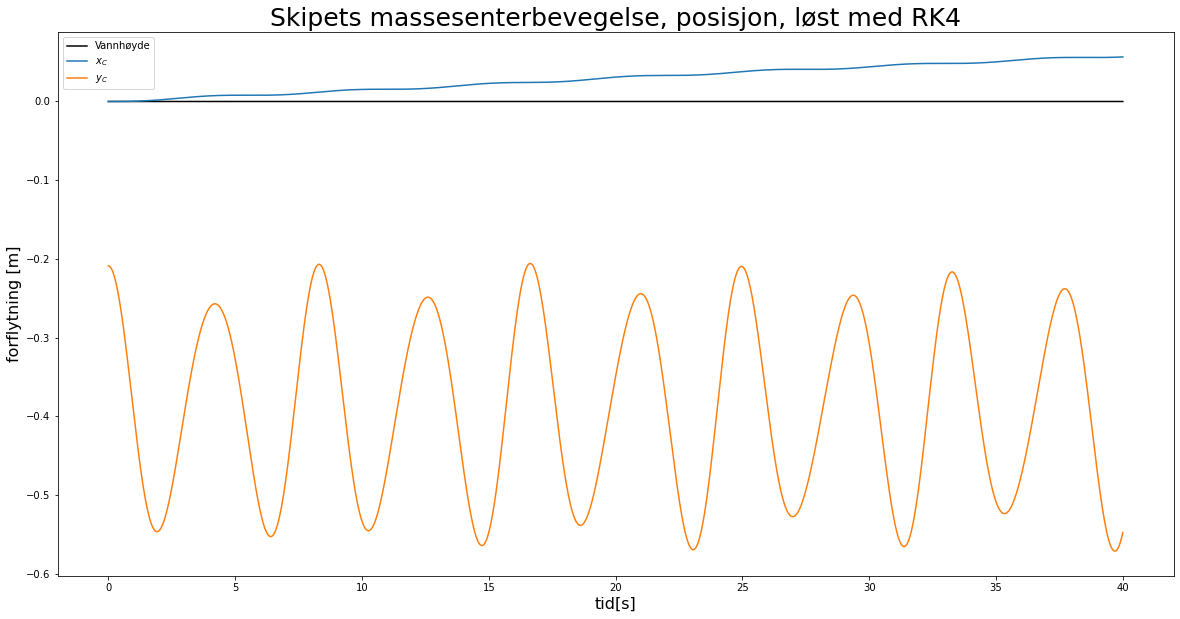

<ipython-input-30-765a0bdc62fc>:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B5464100> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$v_x$', '$v_y$'])


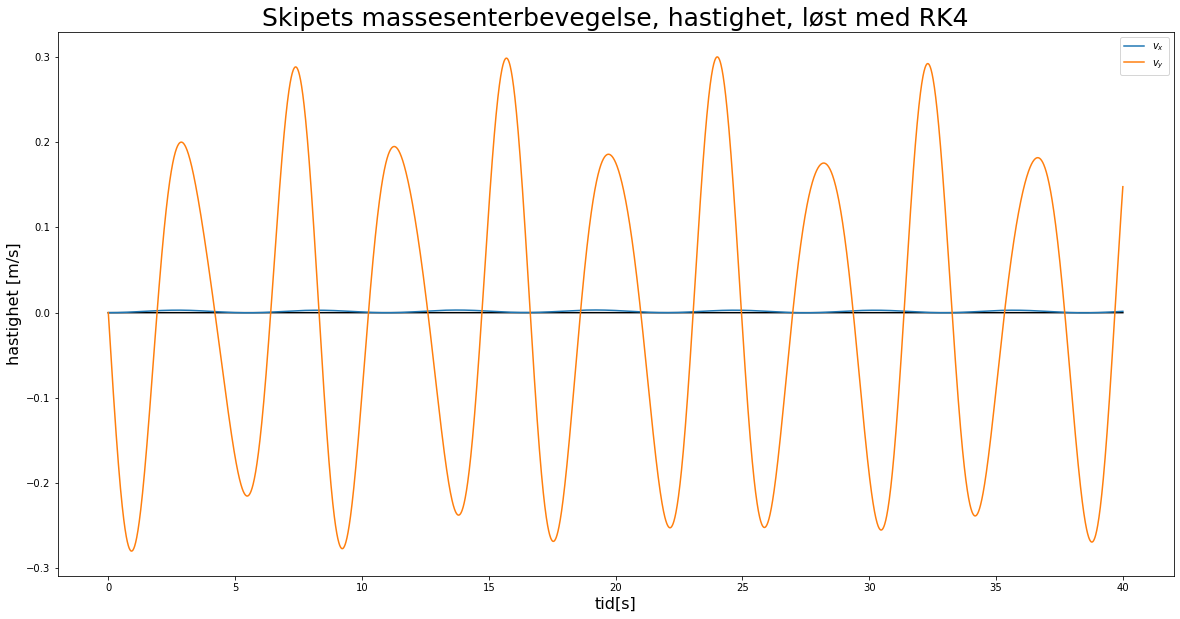

<ipython-input-30-765a0bdc62fc>:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B54BEA90> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$s_L$', '$v_L$'])


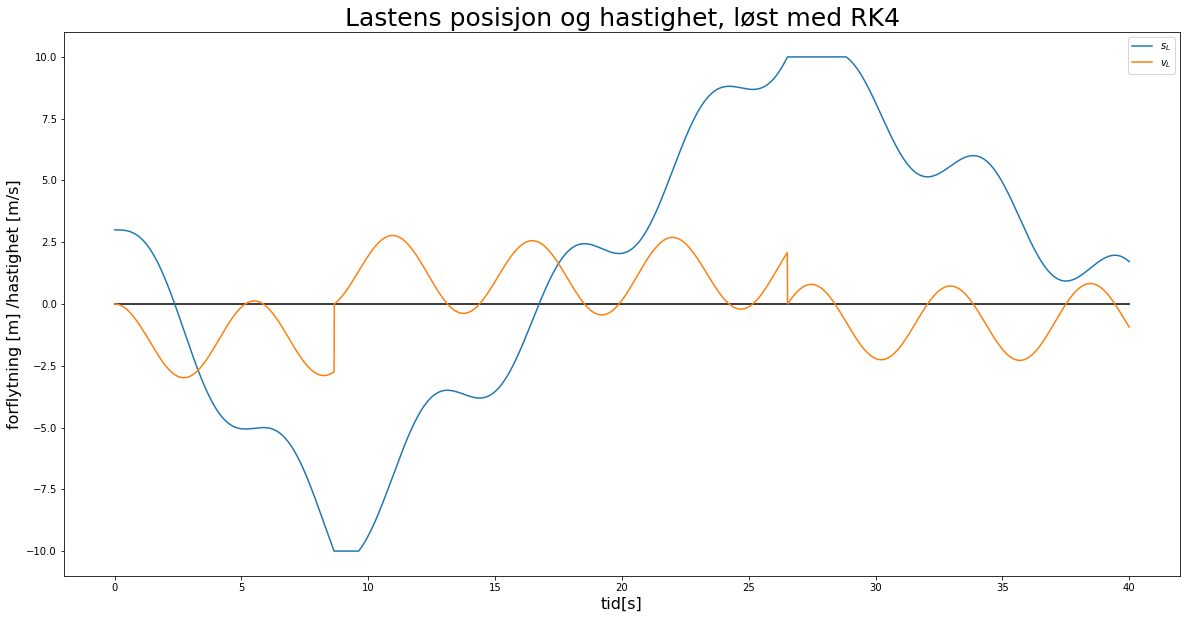

In [30]:
data_2e_0 = np.load('2e_0.npz')

if data_2e_0['time_lost']!=(-1): print(f"Lasten traff gjerdet ved t = {data_2e_0['time_lost']:.2f} s")
if data_2e_0['time_cap']!=(-1): print(f"Skipet kantret ved t = {data_2e_0['time_cap']:.2f} s")

plt.figure(figsize = (20, 10))
plt.plot(data_2e_0['time'], data_2e_0['angles'])
plt.plot(data_2e_0['time'], data_2e_0['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ', '$\omega$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2e_0['time'], np.full(len(data_2e_0['time']), 0), color = 'k')
plt.plot(data_2e_0['time'], data_2e_0['C_position_x'])
plt.plot(data_2e_0['time'], data_2e_0['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m]', fontsize = 16)
plt.legend(['Vannhøyde', '$x_C$', '$y_C$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2e_0['time'], np.full(len(data_2e_0['time']), 0), color = 'k')
plt.plot(data_2e_0['time'], data_2e_0['C_velocity_x'])
plt.plot(data_2e_0['time'], data_2e_0['C_velocity_y'])
plt.title('Skipets massesenterbevegelse, hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$v_x$', '$v_y$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2e_0['time'], np.full(len(data_2e_0['time']), 0), color = 'k')
plt.plot(data_2e_0['time'], data_2e_0['cargo_position'])
plt.plot(data_2e_0['time'], data_2e_0['cargo_velocity'])
plt.title('Lastens posisjon og hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m] /hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$s_L$', '$v_L$'])
plt.show()

Vi observerer at lasten vil skli frem og tilbake på dekk, men vinkelutslagene forblir små nok til at skipet ikke kantrer ved en last med masse $m_L=0.001m$. Vinkelutslaget og vinkelhastigheten er fortsatt harmoniske av natur på grunn av samme grunner som tidligere nevnt, altså ingen dempende krefter. Massesenterets posisjon og hastighet har nå endret seg fra forrige oppgave, og vi ser at mens skipet vil duppe noenlunde harmonisk opp og ned, vil lasten påvirke skipets horisontale bevegelse til å sakte sli lenger og lenger til siden ut fra likevektsposisjonen. Vi kan også se at selv om amplituden på svingningene til hastigheten i x-retning svinger den harmonisk, med et likevektspunkt over 0, som skaper den summative forflytningen bort fra startpunktet. Man kan lett se hvor lasten treffer gjerdene på skipet, siden det gir diskontinuerlige "hakk" i kurvene på forflytning og hastigheten til lasten.

Skipet kantret ved t = 10.58 s


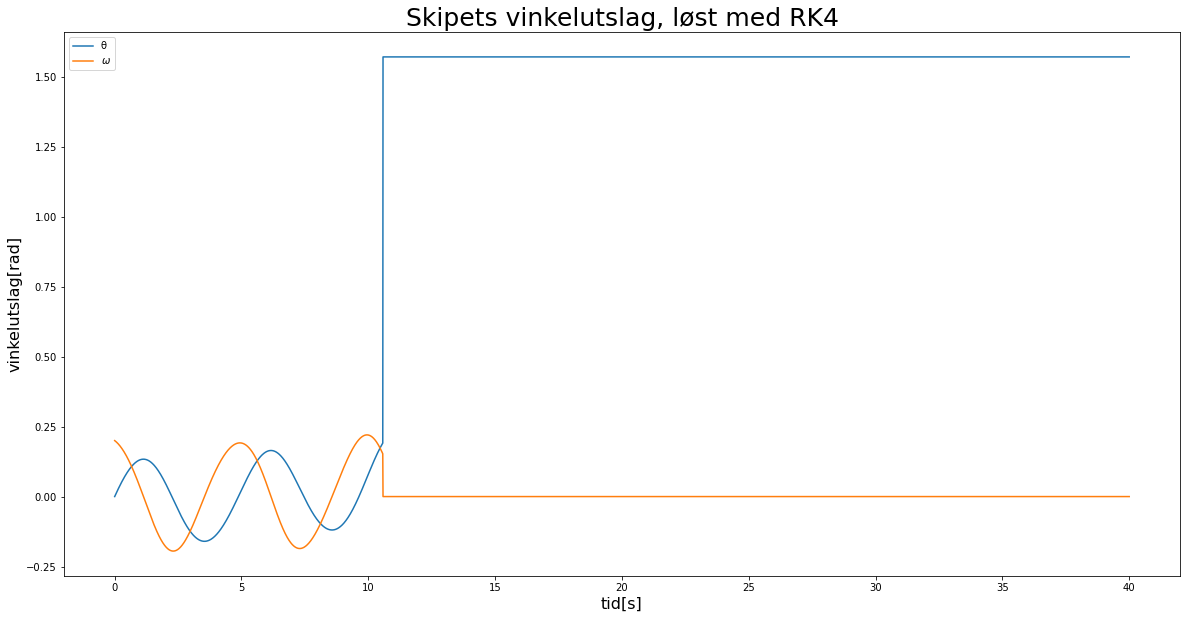

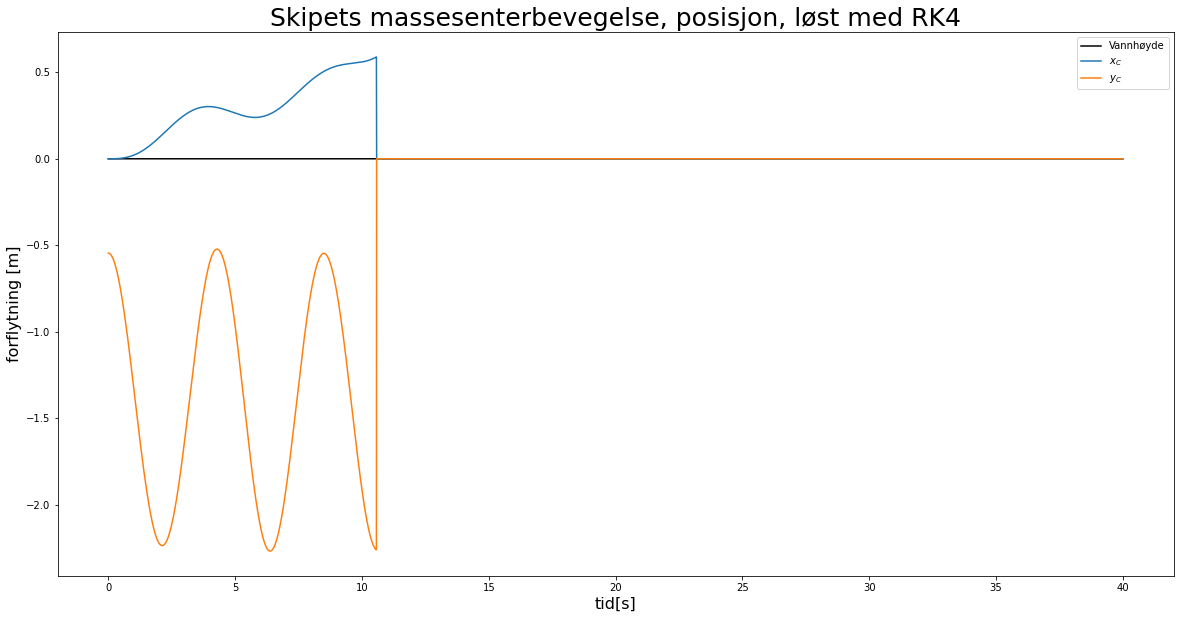

<ipython-input-31-5620ea9bed33>:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B50EEC10> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$v_x$', '$v_y$'])


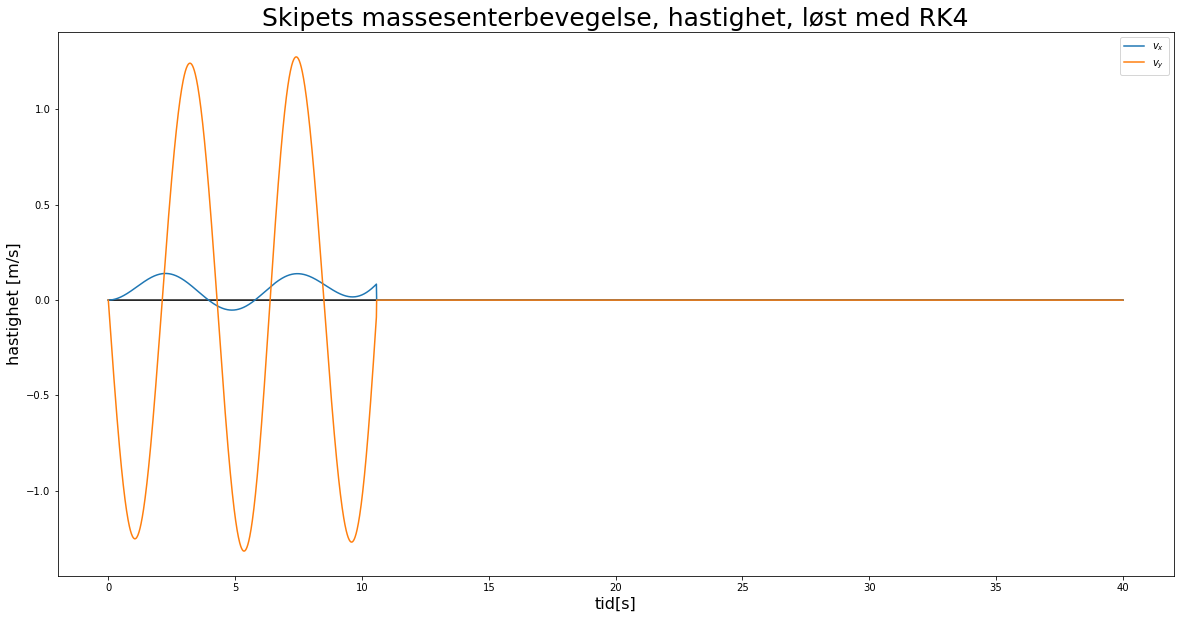

<ipython-input-31-5620ea9bed33>:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B7375340> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$s_L$', '$v_L$'])


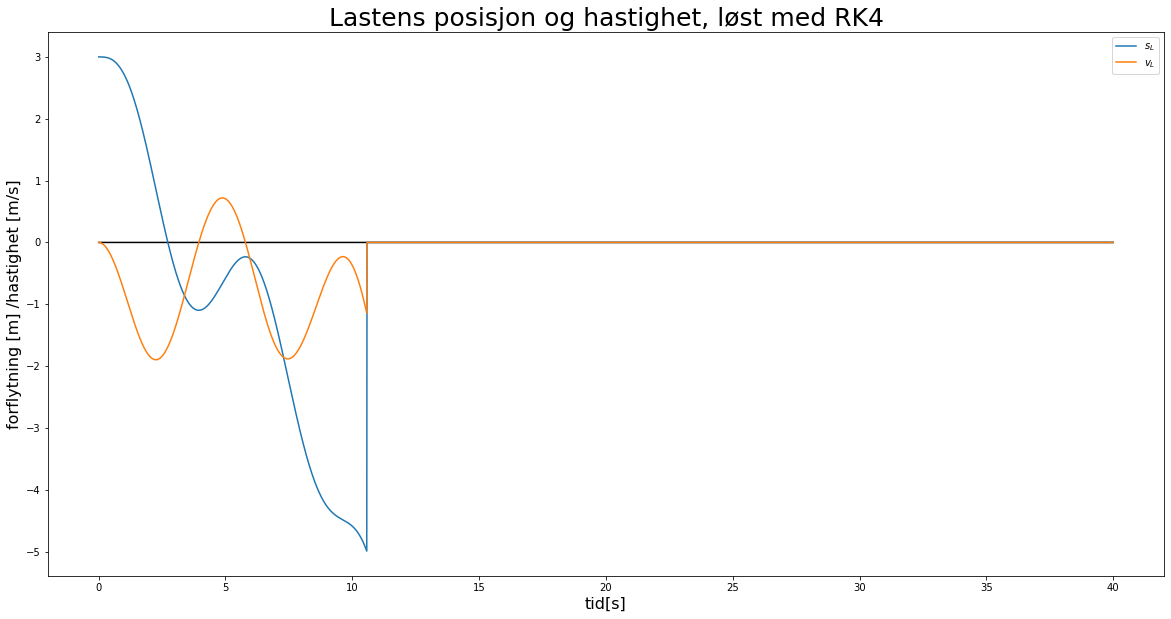

In [31]:
data_2e_1 = np.load('2e_1.npz')

if data_2e_1['time_lost']!=(-1): print(f"Lasten traff gjerdet ved t = {data_2e_1['time_lost']:.2f} s")
if data_2e_1['time_cap']!=(-1): print(f"Skipet kantret ved t = {data_2e_1['time_cap']:.2f} s")

plt.figure(figsize = (20, 10))
plt.plot(data_2e_1['time'], data_2e_1['angles'])
plt.plot(data_2e_1['time'], data_2e_1['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ', '$\omega$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2e_1['time'], np.full(len(data_2e_1['time']), 0), color = 'k')
plt.plot(data_2e_1['time'], data_2e_1['C_position_x'])
plt.plot(data_2e_1['time'], data_2e_1['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m]', fontsize = 16)
plt.legend(['Vannhøyde', '$x_C$', '$y_C$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2e_1['time'], np.full(len(data_2e_1['time']), 0), color = 'k')
plt.plot(data_2e_1['time'], data_2e_1['C_velocity_x'])
plt.plot(data_2e_1['time'], data_2e_1['C_velocity_y'])
plt.title('Skipets massesenterbevegelse, hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$v_x$', '$v_y$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2e_1['time'], np.full(len(data_2e_1['time']), 0), color = 'k')
plt.plot(data_2e_1['time'], data_2e_1['cargo_position'])
plt.plot(data_2e_1['time'], data_2e_1['cargo_velocity'])
plt.title('Lastens posisjon og hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m] /hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$s_L$', '$v_L$'])
plt.show()

Da skipet kantrer for $m_L=0.08m$ før lasten rekker å treffe noen eventuelle gjerder, forblir plottene identiske med simulasjonen uten gjerder.

Til slutt skal vi forbedre realiseringen av skipsmodellen vår ved å ta høyde for friksjonskrefter, vind og bølger. Disse vil komme som tillegg til krefter og dreiemoment som virker på systemet vårt.

Friksjonskraften vi er interessert i er den som oppstår mellom skipets skrog og vannet. Vi antar at denne er proporsjonal med arealet av skipets grenseflate mot vannet, og dermed proporsjonal med buelengden $R\gamma$, samt denne grenseflatens vinkelhastighet. For en friksjonskoeffisient $k_f$ blir dermed friksjonskraften:

$\displaystyle \vec{f} = -k_fR\gamma\omega\hat{x}$

som har en horisontal retning og angrepspunkt i skipets dypeste punkt $D$. Friksjonskraften $f$ gir et bidrag til ytre dreiemoment, med en arm som varierer med vinkelutslaget $\theta$.

I likevekt: $\displaystyle \tau_f = -fY_{CD} =-f(R - h) = -fR(1-\frac{4}{3\pi}) = fR(\frac{4}{3\pi}-1)$

Ved rotasjon og translasjon: $\displaystyle \tau_f = -fY_{CD} =-f(y_D-y_C)=-f(y_M-R-y_C)=-f(R\cos(\gamma/2)-R-y_C)=f(y_C-R\cos(\gamma/2)+R)$

I likevekt forventes skipet da å utføre dempede harmoniske svingninger:

$\displaystyle \theta(t) = \theta_0e^{-\delta t}\sin\omega t$

med tidskonstant $\displaystyle \delta \simeq \frac{k_f\gamma}{m}$ og vinkelfrekvens $\displaystyle \omega = \sqrt{\omega_0^2-\delta^2}$, der $\displaystyle \omega_0 = \sqrt{mgh/I_C}$.

Påvirkningen fra vind og bølger beskriver vi ved en harmonisk horisontalt rettet kraft på tvers av
lengderetningen, definert som:

$\displaystyle F_w(t) = F_0 \cos \omega_wt$

som angriper i høyde med vannlinjen. Bidraget til dreiemomentet blir da:

$\displaystyle \tau_w = F_w y_C$

![figur](https://imgur.com/dB8iwH3.jpg)
**Figur 9:** Angrepspunkt for harmonisk kraft og friksjonskraft

Summen av krefter og dreiemoment på hele systemet blir da:

$\displaystyle \sum\vec{F} = F_G\hat{y} + F_B\hat{y} + F_L^x\hat{x} + F_L^y\hat{y} + f\hat{x} + F_w\hat{x} = m_{tot}\vec{a}_C$

$\displaystyle \Rightarrow a_{x,C} = \frac{1}{m_{tot}}(m_Lg\cos\theta\sin\theta - k_fR\gamma\omega + F_0\cos\omega_wt)$

$\displaystyle \quad a_{y,C} = \frac{1}{m_{tot}}(-m_{tot}g + A\sigma_0g - m_Lg\cos^2\theta)$

$\displaystyle \sum\tau = \tau_B + \tau_L + \tau_f + \tau_w = I_C\frac{d\omega}{dt}$

$\displaystyle \Rightarrow \frac{d\omega}{dt} = \frac{1}{I_C}(-F_Bh\sin\theta + f(y_C-R\cos(\gamma/2)+R) + F_wy_C - m_Lg\cos\theta s_L)$

$\displaystyle\vec{w}(t) = [\theta(t) \quad \omega(t) \quad x_C(t) \quad y_C(t) \quad v_{x,C}(t)\quad v_{y,C}(t) \quad s_L(t) \quad v_L(t)]^T$

$\displaystyle \vec{f}(t, \vec{w}) = \frac{d\vec{w}}{dt} = \left[\omega(t) \quad \frac{d\omega}{dt}(t) \quad v_{x, C}(t) \quad v_{y,C}(t) \quad a_{x,C}(t) \quad a_{y,C}(t) \quad v_L(t) \quad a_L(t)\right]^T$

$\displaystyle = \left[\omega(t) \quad \frac{1}{I_C}(-F_Bh\sin\theta + f(y_C-R\cos(\gamma/2)+R) + F_wy_C - m_Lg\cos\theta s_L) \quad v_{x, C}(t) \quad v_{y,C}(t) \quad \frac{1}{m_{tot}}(m_Lg\cos\theta\sin\theta - k_fR\gamma\omega + F_0\cos\omega_wt) \quad \frac{1}{m_{tot}}(-m_{tot}g + A\sigma_0g - m_Lg\cos^2\theta) \quad v_L(t) \quad -g\sin\theta(t)\right]^T$

Vi ønsker å studere skipets dynamikk uten påvirkning fra lasten, og setter derfor $m_L=0$ for de to følgende oppgavene. Vi starter med å anta at skipet er i rolig farvann, slik at vi kan sette amplituden til den harmoniske kraften lik 0, og fokuserer på friksjonskraften mellom skrog og vann. Vi benytter initialbetingelser $\theta(t = 0) = 0$, $\omega(t = 0) = 0.4$, og plotter interessante størrelser som visualiserer dynamikken for forskjellige verdier og størrelsesordner av $k_f$.

In [32]:
# Oppgave 2f)

def friction(k_f, R, gamma, omega):
    return -k_f*R*gamma*omega

def harmonic_force(F_0, omega_harmonic, t):
    return F_0*np.cos(omega_harmonic*t)

def f_2f(t, z):
    dw = np.array([z[1], 
                    (1/I_C_2[index])*(-area_water(z[0], z[3], beta_array[index])*mass_density_water*g*h*np.sin(z[0]) 
                    + friction(k_f_2f_value, R, gamma(z[0], z[3], beta_array[index]), z[1])*(z[3] 
                    - R*np.cos(gamma(z[0], z[3], beta_array[index])/2) + R) 
                    - mass_cargo[index]*g*z[6]*np.cos(z[0])), 
                    z[4], z[5], 
                    (1/(m_tot[index]))*(mass_cargo[index]*g*np.cos(z[0])*np.sin(z[0])
                    -k_f_2f[9]*R*gamma(z[0], z[3], beta_array[index])*z[1]), 
                    (1/(m_tot[index]))*(-m_tot[index]*g + area_water(z[0], z[3], beta_array[index])*mass_density_water*g
                    -mass_cargo[index]*g*(np.cos(z[0])**2)), 
                    z[7], -g*np.sin(z[0])])
    return dw  

t0, tend = 0, 40
k_f_2f = np.linspace(100, 1000, 10)
k_f_2f_value = k_f_2f[9] # indexen kan endres for å observere endring av dynamikk
index = 2 
z0_2f = np.array([0, 0.4, 0, y_C0(R, beta), 0, 0, 0, 0])

t_num_2f, z_num_2f, t_cap_2f, t_lost_2f = ode_solver(f_2f, t0, tend, z0_2f, step_length, RK4, beta=beta, cap=True, cargo=False, fence=False)
np.savez('2f', time = t_num_2f, angles = z_num_2f[:,0], angular_velocity = z_num_2f[:,1], 
        C_position_x = z_num_2f[:, 2], C_position_y = z_num_2f[:, 3], 
        C_velocity_x = z_num_2f[:, 4], C_velocity_y = z_num_2f[:, 5],
        cargo_position = z_num_2f[:, 6], cargo_velocity = z_num_2f[:, 7],
        time_cap = t_cap_2f, time_lost = t_lost_2f)

k_f=1000.0


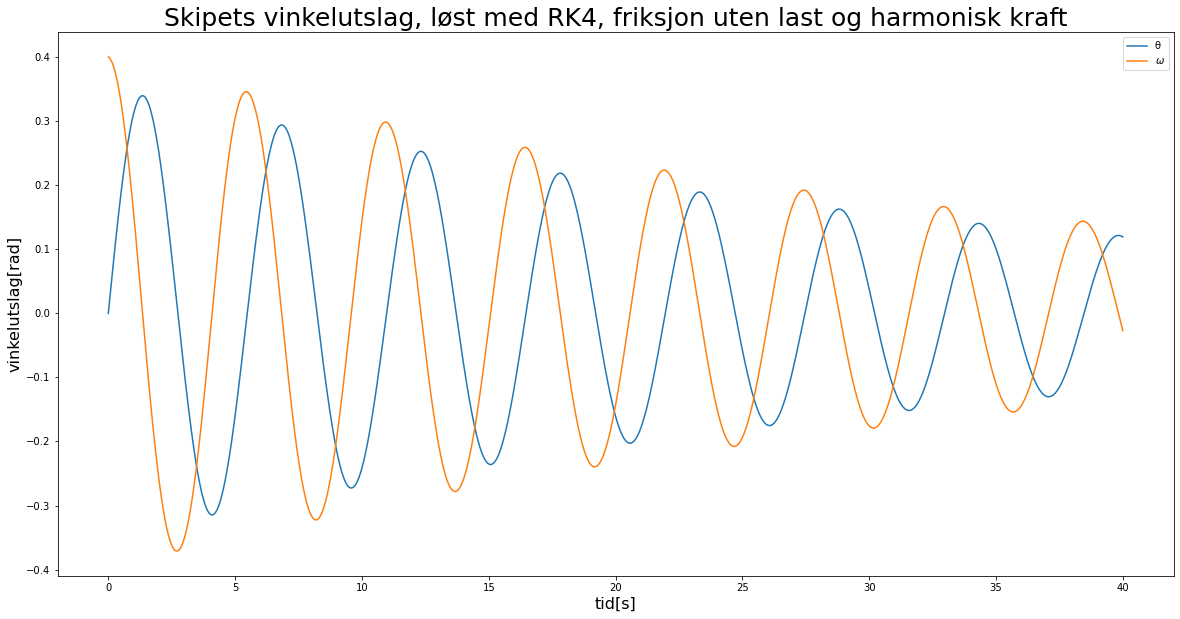

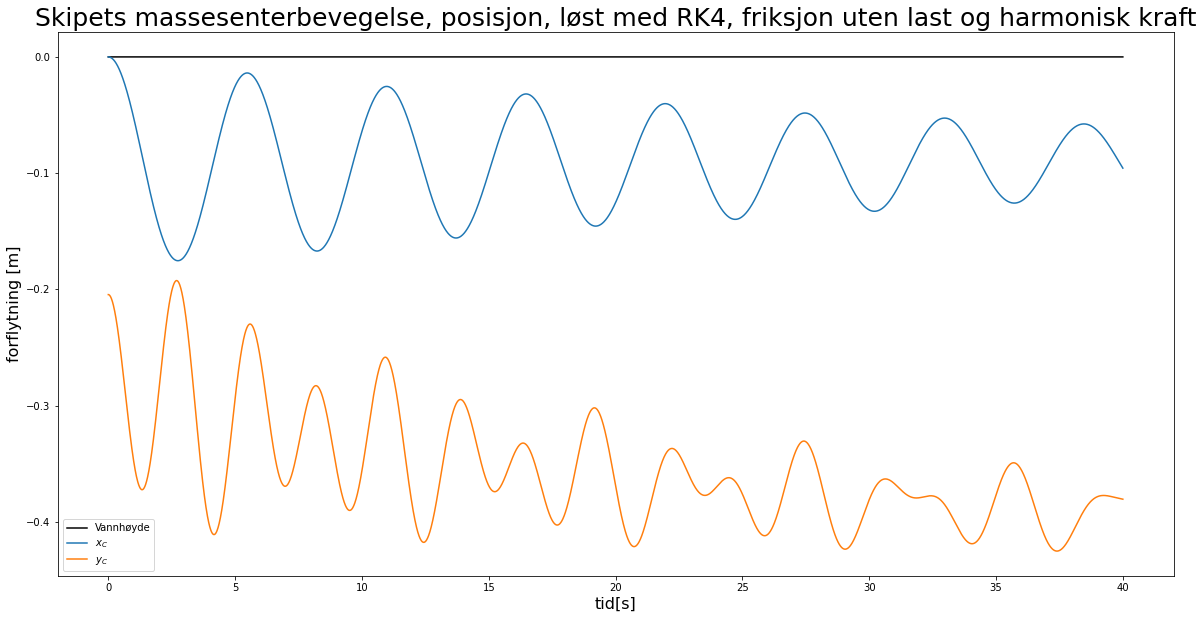

<ipython-input-33-f21697c3154c>:31: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B5457970> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$v_x$', '$v_y$'])


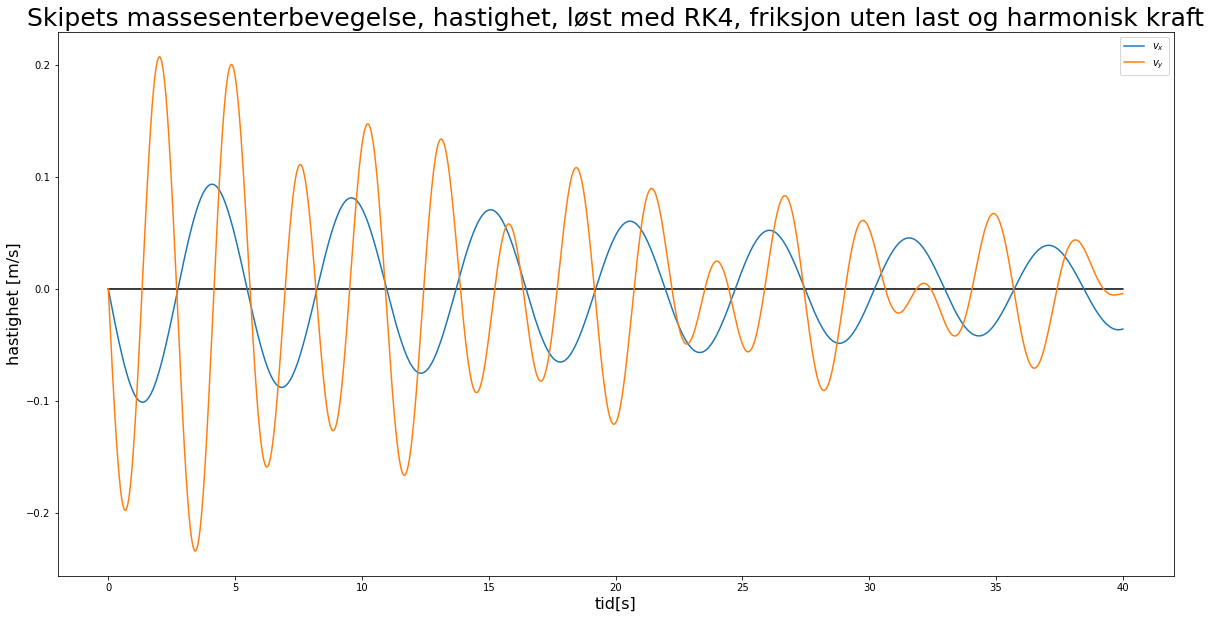

In [33]:
data_2f = np.load('2f.npz')

print(f"k_f={k_f_2f_value}")

if data_2f['time_lost']!=(-1): print(f"Lasten traff gjerdet ved t = {data_2f['time_lost']:.2f} s")
if data_2f['time_cap']!=(-1): print(f"Skipet kantret ved t = {data_2f['time_cap']:.2f} s")

plt.figure(figsize = (20, 10))
plt.plot(data_2f['time'], data_2f['angles'])
plt.plot(data_2f['time'], data_2f['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4, friksjon uten last og harmonisk kraft', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ', '$\omega$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2f['time'], np.full(len(data_2f['time']), 0), color = 'k')
plt.plot(data_2f['time'], data_2f['C_position_x'])
plt.plot(data_2f['time'], data_2f['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4, friksjon uten last og harmonisk kraft', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m]', fontsize = 16)
plt.legend(['Vannhøyde', '$x_C$', '$y_C$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2f['time'], np.full(len(data_2f['time']), 0), color = 'k')
plt.plot(data_2f['time'], data_2f['C_velocity_x'])
plt.plot(data_2f['time'], data_2f['C_velocity_y'])
plt.title('Skipets massesenterbevegelse, hastighet, løst med RK4, friksjon uten last og harmonisk kraft', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$v_x$', '$v_y$'])
plt.show()

Vi har plottet skipets dynamikk for $k_f=1000$kg/s, altså en relativt stor friksjonskoeffisient, for å tydelig se effekten av friksjonskraften. Da friksjonskraften virker i motsatt retning av vinkelutslaget, vil indroduksjonen av friksjon resultere i at skipets utslag minker over tid, det samme skjer med vinkelhastigheten. Vi kan tydelig se effekten av underkritisk demping, altså at kurvene svinger om et likevektspunkt og vil til slutt konvergere mot denne verdien. Vi har relativt lav demping, i forhold til skipets treghetsmoment, slik at det vil ta veldig lang tid før skipet stopper å svinge. Det er ikke bare vinkelutslaget og vinkelhastigheten som har denne underkritiske dempingen, vi kan også se den i skipets forflytning i x-retning og da hastigheten i x-retning. Skipets hastighet i y-retning svinger også, men er litt mer kaotisk og svinger ikke om et gitt likevektspunkt, men ser ut til å nærme seg et ovenifra.

For å se effekten av den harmoniske kraften, plotter vi $\theta$ som funksjon av $t$ fra
$t = 0$ til $t = 240$, med parametre $k_f = 100$ kg/s, $F_0 = 0.625mg$, $\displaystyle \omega_w = 0.93\omega_0 = 0.93 \sqrt{mgh/IC}$, og initialbetingelser $\theta(t = 0) = 0$, $\omega(t = 0) = 2^{\circ}$/s $= 2\pi/180$rad/s.

In [34]:
# Oppgave 2g)

def f_2g(t, z):
    dw = np.array([z[1], 
                    (1/I_C_2[index])*(-g*area_water(z[0], z[3], beta_array[index])*mass_density_water*h*np.sin(z[0]) 
                    + friction(k_f, R, gamma(z[0], z[3], beta_array[index]), z[1])*(z[3] 
                    - R*np.cos(gamma(z[0], z[3], beta_array[index])/2) + R) + harmonic_force(F_0, omega_w, t)*z[3]
                    - mass_cargo[index]*g*z[6]*np.cos(z[0])), 
                    z[4], z[5], 
                    1/(m_tot[index])*(mass_cargo[index]*g*np.cos(z[0])*np.sin(z[0])
                    -k_f*R*gamma(z[0], z[3], beta_array[index])*z[1] + harmonic_force(F_0, omega_w, t)), 
                    1/(m_tot[index])*(-m_tot[index]*g + area_water(z[0], z[3], beta_array[index])*mass_density_water*g
                    -mass_cargo[index]*g*(np.cos(z[0])**2)), 
                    z[7], -g*np.sin(z[0])])
    return dw

index = 2
k_f = 100
F_0 = 0.0625*m_tot[index]*g
omega_w = 0.93*np.sqrt(m_tot[index]*g*h/I_C_2[index])
z0_2g = np.array([0, 2*np.pi/180, 0, y_C0(R, beta), 0, 0, 0, 0])
t0_big, tend_big = 0, 240

t_num_2g, z_num_2g, t_cap_2g, t_lost_2g = ode_solver(f_2g, t0_big, tend_big, z0_2g, step_length, RK4, beta=beta, cap=True, cargo=False, fence=False)
np.savez('2g', time = t_num_2g, angles = z_num_2g[:,0], angular_velocity = z_num_2g[:,1], 
        C_position_x = z_num_2g[:, 2], C_position_y = z_num_2g[:, 3], 
        C_velocity_x = z_num_2g[:, 4], C_velocity_y = z_num_2g[:, 5],
        cargo_position = z_num_2g[:, 6], cargo_velocity = z_num_2g[:, 7],
        time_cap = t_cap_2g, time_lost = t_lost_2g)


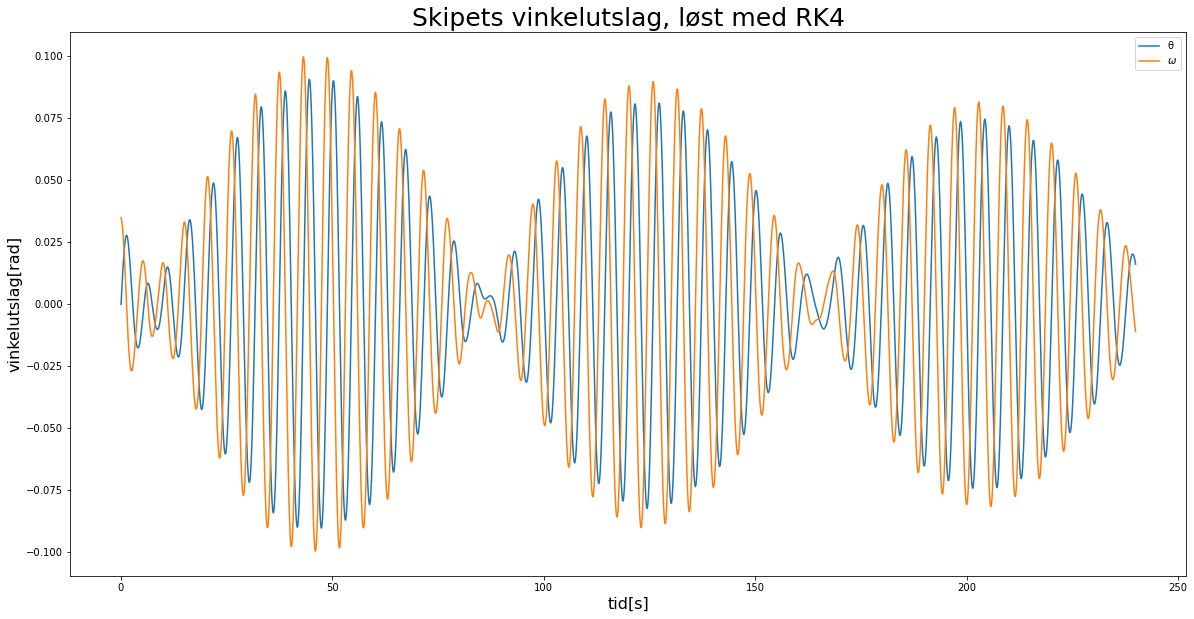

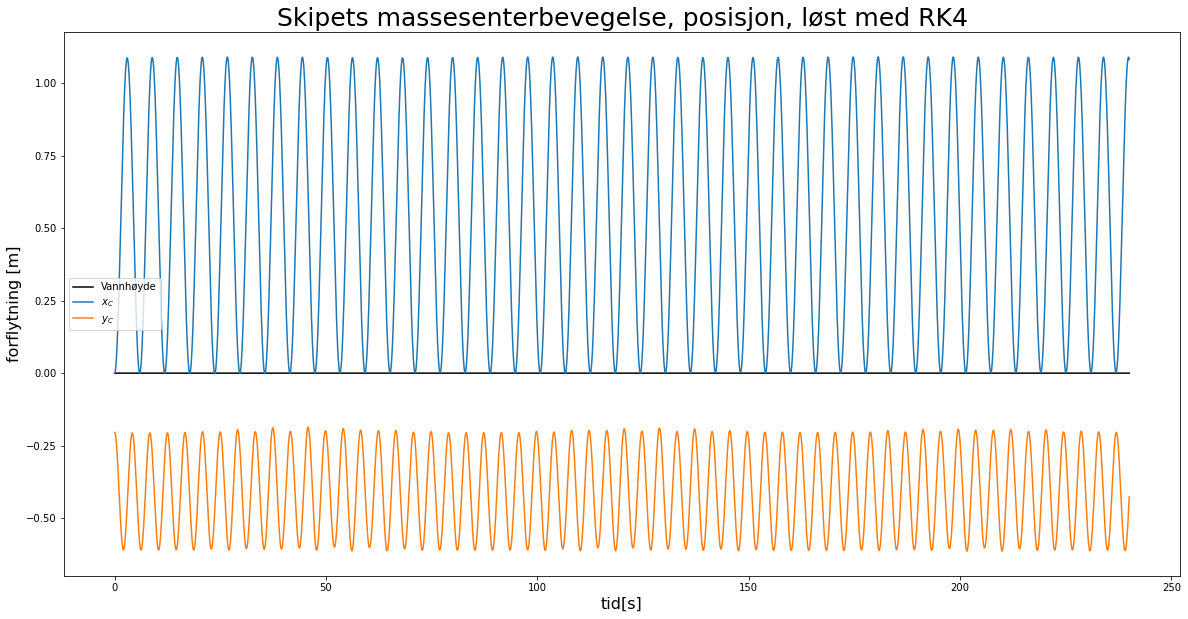

<ipython-input-35-55b0a8b9f25d>:29: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B8C1ACA0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$v_x$', '$v_y$'])


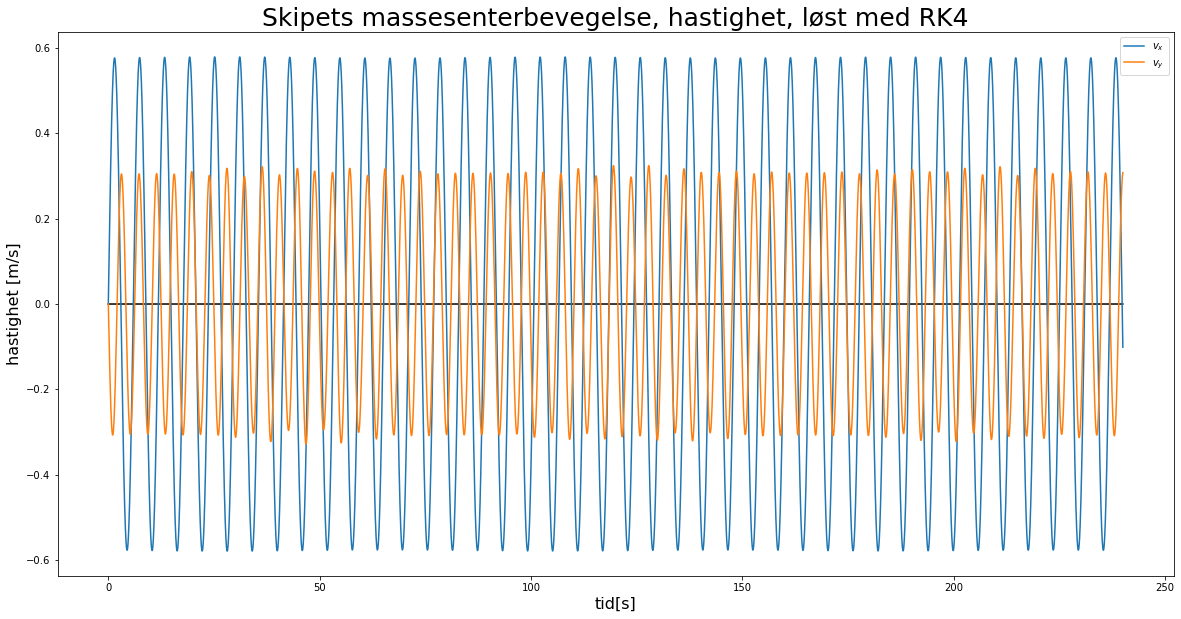

In [35]:
data_2g = np.load('2g.npz')

if data_2g['time_lost']!=(-1): print(f"Lasten traff gjerdet ved t = {data_2g['time_lost']:.2f} s")
if data_2g['time_cap']!=(-1): print(f"Skipet kantret ved t = {data_2g['time_cap']:.2f} s")

plt.figure(figsize = (20, 10))
plt.plot(data_2g['time'], data_2g['angles'])
plt.plot(data_2g['time'], data_2g['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ', '$\omega$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2g['time'], np.full(len(data_2g['time']), 0), color = 'k')
plt.plot(data_2g['time'], data_2g['C_position_x'])
plt.plot(data_2g['time'], data_2g['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m]', fontsize = 16)
plt.legend(['Vannhøyde', '$x_C$', '$y_C$'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2g['time'], np.full(len(data_2g['time']), 0), color = 'k')
plt.plot(data_2g['time'], data_2g['C_velocity_x'])
plt.plot(data_2g['time'], data_2g['C_velocity_y'])
plt.title('Skipets massesenterbevegelse, hastighet, løst med RK4', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$v_x$', '$v_y$'])
plt.show()

Når vi legger til en ytre harmonisk kraft (typisk bølger eller vind), får vi fenomenet svevning. Vi kan se at kurvene for vinkelutslaget og vinkelhastigheten begge opplever dette fenomenet, samtidig som de er underkritisk dempet (på grunn av friksjon). Både $\theta$ og $\omega$ er en sum av to ulike sinusbølger med ulike frekvenser, den harmoniske krafta fra omgivelsene med $\omega = 0.93\omega_0$ og svingningen skipet har i utgangspunktet med $\omega$. Svevningen ser ut som en sinusbølge, med en annen sinusbølge "på innsiden" men med mye høyere frekvens og amplituden til den første sinusbølgen i et gitt punktet. Dersom den harmoniske krafta hadde hatt en frekvens på $\omega = \omega_0$, så hadde vi fått resonans. Altså at en ytre kraft har samme frekvens som systemets egenfrekvens. Da ville vi nok sett at skipet ville kantret etter ganske kort tid, siden den harmoniske krafta kun vil jobbe med og ikke mot. I vårt tilfelle vil den harmoniske krafta veksle mellom å jobbe med og i mot, som er da man får svevning. 

Det kan også være verdt å merke seg forflytningen og hastigheten i bde x- og y-retning svinger harmonisk. Amplituden til kurvene som beskriver bevegelse i y-retning er ikke konstant, men variasjonen er veldig liten og den svinger om et likevektspunkt, så den er ikke så langt unna en harmonisk svingefunksjon. Det at bevegelse i x-retning har en mer harmonisk oppførsel nå enn i tidligere plot, er fordi den harmoniske krafta virker i x-retning og overstyrer de andre kreftene som påvirker horisontal bevegelse. Siden den harmoniske krafta ikke virker i y-retning, ligner da disse plottene mer på de vi tidligere har sett.

Vi har som nevnt benyttet RK4-metoden til å løse de ordinære differentiallikningene som beskrivet dynamikken til skipet vårt. RK4-metoden er tilstrekkelig i mange tilfeller, men har også sine begrensninger, og det finnes mange diffligninger som ikke lar seg løse ved bruk av RK4. I siste del av prosjektet vårt ønsker vi derfor å implementere en annen ODE-løser, og se på et interessant problem knyttet til skipets stabilitet, der vi sammenligner løseren vår med RK4 for å diskutere fordelene og ulempene med denne løseren.

Vi bestemte oss for å benytte Bogacki-Shampine-metoden, som vi har fått erfaring med gjennom øving 4, med Butcher-tableu: 
$$
\begin{array}{c|cccccl}
    0 & 0 \\ 
    1/2 & 1/2  \\ 
    3/4 & 0 & 3/4 \\ 
    1 & 2/9 & 1/3 & 4/9 \\ \hline
       & 2/9 & 1/3 & 4/9 & 0  & & \quad & Bogacki \\ \hline
       & 7/24 & 1/4 & 1/3 & 1/8 & &  & Shampine 
   \end{array}
$$
der Bogacki er av orden $p=3$ og Shampine er av orden $p=2$. Metoden ser som følger ut:

$\displaystyle \textbf{k}_1 = \textbf{f}(x_n,\textbf{y}_n)$

$\displaystyle \textbf{k}_2 = \textbf{f}(x_n+\frac{1}{2}h, \textbf{y}_n+\frac{1}{2}h\textbf{k}_1)$

$\displaystyle \textbf{k}_3 = \textbf{f}\big(x_n+\frac{3}{4}h, \textbf{y}_n+\frac{3}{4}h\textbf{k}_2\big)$

$\displaystyle \textbf{k}_4 = \textbf{f}\big(x_n+h, \textbf{y}_n + h(\frac{2}{9}\textbf{k}_1 + \frac{1}{3}\textbf{k}_2 + \frac{4}{9}\textbf{k}_3)\big)$

$\displaystyle \textbf{y}_{n+1} = \textbf{y}_n + h(\frac{2}{9} \textbf{k}_1 + \frac{1}{3} \textbf{k}_2+ \frac{4}{9} \textbf{k}_3)$

$\displaystyle \widehat{\textbf{y}}_{n+1} = \textbf{y}_n + h(\frac{7}{24} \textbf{k}_1 + \frac{1}{4} \textbf{k}_2+ \frac{1}{3} \textbf{k}_3 + \frac{1}{8} \textbf{k}_4)$

$\displaystyle \textbf{le}_{n+1} = \|\widehat{\textbf{y}}_{n+1} - \textbf{y}_{n+1}\| = h\cdot\|\frac{5}{72}\textbf{k}_1  - \frac{1}{12} \textbf{k}_2 - \frac{1}{9} \textbf{k}_3 +  \frac{1}{8} \textbf{k}_4\|$

Vi observerer at Bogacki-Shampine oppfyller FSAL egenskapen, siden $\displaystyle \textbf{k}_4 = \textbf{f}\big(x_n+h, \textbf{y}_n + h(\frac{2}{9}\textbf{k}_1 + \frac{1}{3}\textbf{k}_2 + \frac{4}{9}\textbf{k}_3)\big) = \textbf{f}(x_{n+1},\textbf{y}_{n+1}) = \textbf{k}_1$ i neste steg.

Denne metoden tillater oss å implementere en steglengde-kontroll, slik at vi kan øke antall steg der funksjonen vår behøver det. Vi ønsker en steglengde som oppfyller et lokalt feilestimat $\displaystyle\|\textbf{le}_{n+1}\| \leq \text{Tol}$ for en gitt toleranse. Det kan vises at $\displaystyle\| \textbf{le}_{n+1} \| \approx D  h_{n}^{p+1}$ for en ukjent verdi $D$ som kan antas tilnærmet konstant fra ett steg til et annnet, og vi ønsker altså en $\displaystyle h_{new}$ slik at $\displaystyle \text{Tol} \approx D h_{new}^{p+1}$. Denne kan utledes fra approksimasjonene, der 

$\displaystyle \frac{\text{Tol}}{\|\textbf{le}_{n+1}\|} \approx \left(\frac{h_{new}}{h_n}\right)^{p+1} \qquad \Rightarrow \qquad h_{new} \approx \left( \frac{\text{Tol}}{\|\textbf{le}_{n+1}\|} \right)^{\frac{1}{p+1}} h_{n}$

hvor vi så innleder en pessimistfaktor $P<1$ for å unngå en urimelig liten steglengde, slik at

$\displaystyle h_{new} = P\cdot \left( \frac{\text{Tol}}{\|\textbf{le}_{n+1}\|} \right)^{\frac{1}{p+1}} h_{n}$

In [36]:
# Oppgave 2h)
def bogshamp(f,t,z,h,k):
    k1 = k
    k2 = f(t+(h/2),z+(h*k1/2))
    k3 = f(t+(h*3/4),z+(3*h*k2/4))
    z_next = z + h*((2*k1/9)+(k2/3)+(4*k3/9)) #lokal ekstrapolasjon, metode 1 har høyere orden enn metode 2
    t_next = t+h
    k4 = f(t_next,z_next)
    error_estimate = h*np.linalg.norm((5*k1/72)-(k2/12)-(k3/9)+(k4/8))
    return t_next, z_next, error_estimate, k4

def bogshamp_adaptive(f, t0, tend, z0, h0, tol, beta=beta, cap=False, cargo=False, fence=False):
    z_num = np.array([z0])
    t_num = np.array([t0])
    tn = t0
    zn = z0
    h = h0
    k = f(tn,zn)
    Maxcall = 100000        # Maximum allowed calls of method
    ncall = 0
    t_cap = np.zeros(1)
    t_lost = np.zeros(1)
    f_original = f
    while tn < tend - 1.e-10:               # Buffer for truncation error
        if tn + h > tend:                   
            h = tend - tn 
        t_try, z_try, error_estimate, k_try = bogshamp(f, tn, zn, h, k)
        ncall = ncall + 1
        
        if error_estimate <= tol:   
            # Solution accepted, update t and y
            tn = t_try    
            zn = z_try
            k = k_try
            if cap:
                if check_capsize(zn[0], zn[3], beta) or f==f_cap: 
                    if len(zn)==8:
                        zn=np.array([np.sign(zn[0])*np.pi/2, 0, 0, 0, 0, 0, 0, 0])
                    else:
                        zn=np.array([np.sign(zn[0])*np.pi/2, 0, 0, 0, 0, 0])
                    t_cap = np.append(t_cap,tn)
                    f=f_cap
            if cargo and not fence:
                if abs(zn[6]) > R:
                    zn[6] = 0 #np.sign(zn[6])*(R+1)
                    zn[7] = 0
                    t_lost = np.append(t_lost, tn)
                    f = f_lost
            if cargo and fence:
                if abs(zn[6]) >= R:
                    zn[6] = np.sign(zn[6])*(R)
                    zn[7] = 0
                    t_lost = np.append(t_lost, tn)
                    f = f_lost_fence
                if np.sign(zn[1])!=np.sign(zn[6]): f = f_original
            z_num = np.concatenate((z_num, np.array([zn])))
            t_num = np.append(t_num, tn)
        # else: The step is rejected and nothing is updated. 
        
        h = 0.8*h*(tol/error_estimate)**(1/3)
        
        # Stop with a warning in the case of max calls to method
        if ncall > Maxcall:
            print('Maximum number of method calls')
            return t_num, z_num
    if len(t_cap)>1: t_cap = t_cap[1]
    else: t_cap=-1 
    if len(t_lost)>1: t_lost = t_lost[1]
    else: t_lost=-1
    return t_num, z_num, t_cap, t_lost

Vi ser så på interessant problem for å kunne sammenlikne Bogacki-Shampine-løseren og RK4. Først studerer vi om vi oppdager noen avvik dersom vi inkluderer alle krefter, dreiemomenter og faktorer introdusert sålangt i prosjektet. Vi benytter intitialverdiene $\theta_0=3^{\circ}$, $\omega_0=2^{\circ}$, $m_L=0.001m$, $s_L=0$, $k_f=200$, $F_0=0.5mg$, og $\omega_w=0.8\omega_0$.

In [37]:
def f_2h(t, z):
    dw = np.array([z[1], 
                    (1/I_C_2[index])*(-g*area_water(z[0], z[3], beta_array[index])*mass_density_water*h*np.sin(z[0]) 
                    + friction(k_f, R, gamma(z[0], z[3], beta_array[index]), z[1])*(z[3] 
                    - R*np.cos(gamma(z[0], z[3], beta_array[index])/2) + R) + harmonic_force(F_0, omega_w, t)*z[3] 
                    - mass_cargo[index]*g*z[6]*np.cos(z[0])), 
                    z[4], z[5], 
                    1/(m_tot[index])*(mass_cargo[index]*g*np.cos(z[0])*np.sin(z[0]) 
                    - k_f*R*gamma(z[0], z[3], beta_array[index])*z[1] + harmonic_force(F_0, omega_w, t)), 
                    1/(m_tot[index])*(-m_tot[index]*g + area_water(z[0], z[3], beta_array[index])*mass_density_water*g 
                    - mass_cargo[index]*g*(np.cos(z[0]))**2), 
                    z[7], -g*np.sin(z[0])])
    return dw

index = 0
tol = 10**(-8)
k_f = 200
F_0 = 0.5*m_tot[index]*g
omega_w = 0.8*np.sqrt(m_tot[index]*g*h/I_C_2[index])
z0_2h = np.array([3*np.pi/180, 2*np.pi/180, 0, y_C0(R, beta_array[index]), 0, 0, 0, 0])



t_num_2h, z_num_2h, t_cap_2h, t_lost_2h = ode_solver(f_2h, t0, tend_big, z0_2h, step_length, RK4, beta=beta_array[index], cap=True, cargo=True, fence=True)
t_num_2h_bs, z_num_2h_bs, t_cap_2h_bs, t_lost_2h_bs = bogshamp_adaptive(f_2h, t0, tend_big, z0_2h, step_length, tol, beta=beta_array[index], cap=True, cargo=True, fence=True)

np.savez('2h', time = t_num_2h, angles = z_num_2h[:,0], angular_velocity = z_num_2h[:,1], 
        C_position_x = z_num_2h[:, 2], C_position_y = z_num_2h[:, 3], 
        C_velocity_x = z_num_2h[:, 4], C_velocity_y = z_num_2h[:, 5],
        cargo_position = z_num_2h[:, 6], cargo_velocity = z_num_2h[:, 7],
        time_cap = t_cap_2h, time_lost = t_lost_2h)

np.savez('2h_bs', time = t_num_2h_bs, angles = z_num_2h_bs[:,0], angular_velocity = z_num_2h_bs[:,1], 
        C_position_x = z_num_2h_bs[:, 2], C_position_y = z_num_2h_bs[:, 3], 
        C_velocity_x = z_num_2h_bs[:, 4], C_velocity_y = z_num_2h_bs[:, 5],
        cargo_position = z_num_2h_bs[:, 6], cargo_velocity = z_num_2h_bs[:, 7],
        time_cap = t_cap_2h_bs, time_lost = t_lost_2h_bs)

RK4-Lasten traff gjerdet ved t = 25.50 s
BogShamp-Lasten traff gjerdet ved t = 25.50 s


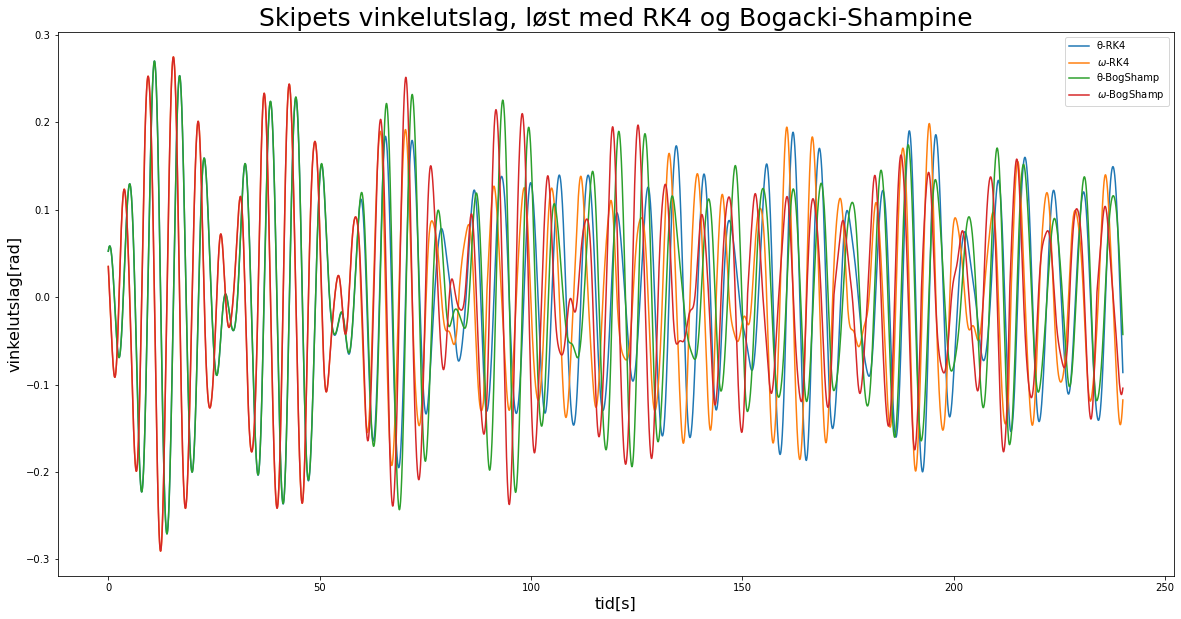

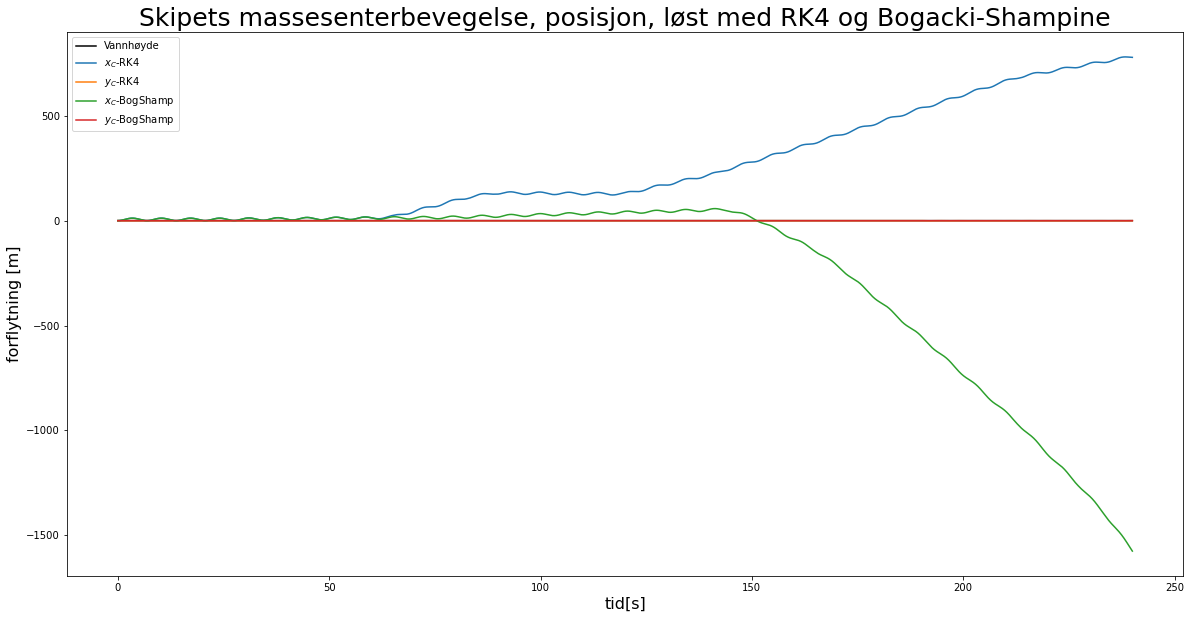

<ipython-input-38-d64935448cf6>:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B7398730> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$s_L$-RK4', '$v_L$-RK4', '$s_L$-BogShamp', '$v_L$-BogShamp'])


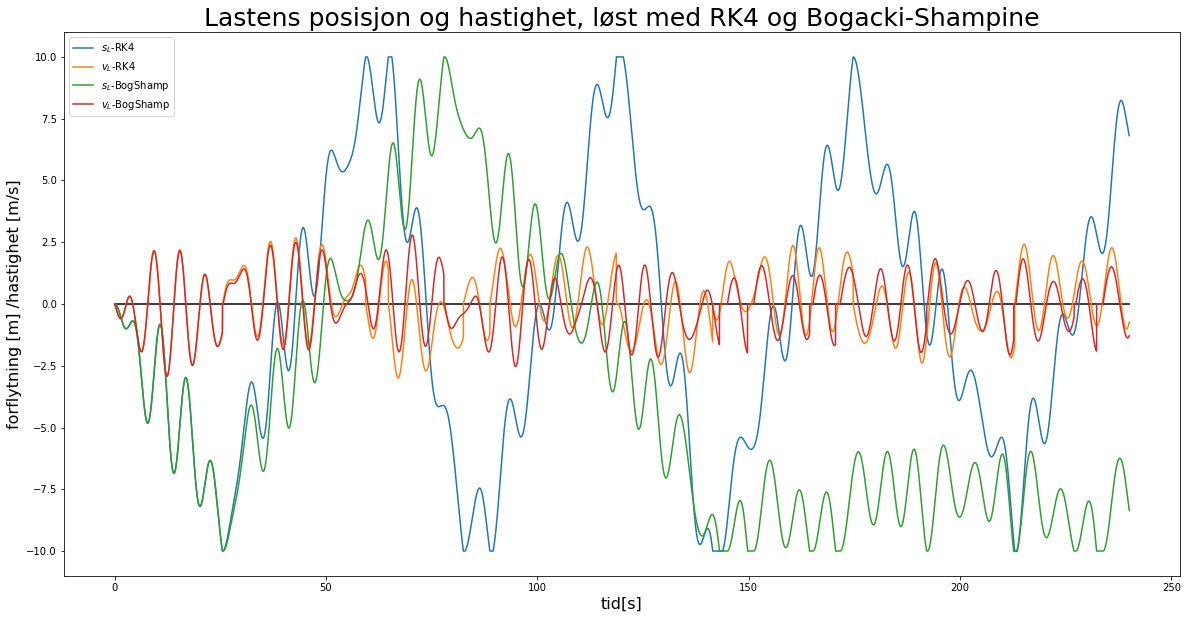

In [38]:
data_2h = np.load('2h.npz')
data_2h_bs = np.load('2h_bs.npz')

if data_2h['time_lost']!=(-1): print(f"RK4-Lasten traff gjerdet ved t = {data_2h['time_lost']:.2f} s")
if data_2h['time_cap']!=(-1): print(f"RK4-Skipet kantret ved t = {data_2h['time_cap']:.2f} s")
if data_2h_bs['time_lost']!=(-1): print(f"BogShamp-Lasten traff gjerdet ved t = {data_2h_bs['time_lost']:.2f} s")
if data_2h_bs['time_cap']!=(-1): print(f"BogShamp-Skipet kantret ved t = {data_2h_bs['time_cap']:.2f} s")

plt.figure(figsize = (20, 10))
plt.plot(data_2h['time'], data_2h['angles'])
plt.plot(data_2h['time'], data_2h['angular_velocity'])
plt.plot(data_2h_bs['time'], data_2h_bs['angles'])
plt.plot(data_2h_bs['time'], data_2h_bs['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4 og Bogacki-Shampine', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ-RK4', '$\omega$-RK4', 'θ-BogShamp', '$\omega$-BogShamp'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2h_bs['time'], np.full(len(data_2h_bs['time']), 0), color = 'k')
plt.plot(data_2h['time'], data_2h['C_position_x'])
plt.plot(data_2h['time'], data_2h['C_position_y'])
plt.plot(data_2h_bs['time'], data_2h_bs['C_position_x'])
plt.plot(data_2h_bs['time'], data_2h_bs['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4 og Bogacki-Shampine', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m]', fontsize = 16)
plt.legend(['Vannhøyde', '$x_C$-RK4', '$y_C$-RK4', '$x_C$-BogShamp', '$y_C$-BogShamp'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_2h_bs['time'], np.full(len(data_2h_bs['time']), 0), color = 'k')
plt.plot(data_2h['time'], data_2h['cargo_position'])
plt.plot(data_2h['time'], data_2h['cargo_velocity'])
plt.plot(data_2h_bs['time'], data_2h_bs['cargo_position'])
plt.plot(data_2h_bs['time'], data_2h_bs['cargo_velocity'])
plt.title('Lastens posisjon og hastighet, løst med RK4 og Bogacki-Shampine', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m] /hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$s_L$-RK4', '$v_L$-RK4', '$s_L$-BogShamp', '$v_L$-BogShamp'])
plt.show()

I denne simulasjonen oppdaget vi at etter at lasten vår traff gjerdet for første gang, ville RK4 metoden og løseren vår begynne å divergere. Da Bogacki-Shampine er av høyere orden og implementerer steglengde-kontroll, er nok dette en mer nøyaktig metode for å løse systemet. Vi har simulert et utrolig kaotisk system, og med mange innspillende faktorer, så det er ikke urimelig at det er krevende for RK4 å holde følge. Vi har også simulert systemet med en veldig stor sluttid, som gir metodene flere muligheter til å divergere fra hverandre. Overraskende nok begynner skipet å bevege seg i motsatt horisontal retning mellom de to metodene, samt lastens posisjon vil overholde en periodisk svingning med RK4, men forbli på kun den ene siden av dekk med Bogacki-Shampine. Selv om verdiene vi har valgt muligens ikke er særlig realistiske og derfor gir så store variasjoner mellom valg av metoder, fikk vi fortsatt et godt inntrykk av de ulike løsernes gyldighetsområde.

Helt til slutt tenkte vi det kunne være interessant å studere hvordan vår betydelig forenklede modell vil fungere dersom vi benytter mer realistiske verdier og parametre. Da dette prosjektets inspirasjon var kantringen og synkingen av det svenske orlogsskipet Vasa, ønsket vi å lete på nett etter relevante verdier for Vasaskipet, og se om skipet ville kantret dersom det var bygget etter vår "feilfrie og perfekte" modell. For det første var Vasa $11.7$ m bred (Wisting, 2022). Det var bygget av europeisk eik (Ljungdahl, 2006), med en massetetthet rundt $650$ kg/m$^3$ (Javier, et al. 2009). Vinden var omtrent fire m/s (Fairley og Willshire, 2003). Vekten var $8e5$ kg, hvorav det var 46 kanoner à 1250kg, 8 med 400 og 10 mindre, anslått til 100 kg (vasamuseet, 202). Det var 450 mannskap,antatt gjennomsnittsvekt 80 kg (Ibid.) Skpet sank etter 20 minutter, ved en helling  på 10 grader  (Javier et al. 2009). 

In [39]:
R_Vasa = 11.7/2
mass_density_Vasa = 650 
#m_Vasa = 8e5 #total masse av hele skipet
#m_L_Vasa = 450*80 + 46*1250 + 8*400 +10*100 #total last på hele skipet

wind_speed_Vasa = 4.12  # m/s
F_0_wind = 1.225*wind_speed_Vasa**2   #massetetthet til luft er tilnærmet 1.225 ved 25°C

capsize_angle_Vasa = 10  #grader
t_capsize_Vasa = 20*60 #s

cross_section_Vasa = 1/2 * np.pi * R_Vasa**2 
m_cross_Vasa = cross_section_Vasa*mass_density_Vasa 
I_C_Vasa = 1/2 * m_cross_Vasa * R_Vasa**2 * (1-32/(9*np.pi**2))
h_Vasa = 4*R_Vasa/(3*np.pi)
m_Vasa = m_cross_Vasa*mass_density_Vasa #masse per lengdeenhet
m_L_Vasa = 0.001*m_Vasa #m_L per lengdeenhet

beta0 = np.array([1.5])
mass_density_ship = mass_density_Vasa
beta_Vasa_array, nit_Vasa = newton(f_beta, df_beta, beta0, tol=1.e-14, max_iter=15)  # Apply Newton
beta_Vasa = beta_Vasa_array[0]

In [40]:
def f_Vasa(t, z):
    dw = np.array([z[1], 
                    (1/I_C_Vasa)*(-g*area_water(z[0], z[3], beta_Vasa)*mass_density_water*h*np.sin(z[0]) 
                    + friction(k_f, R, gamma(z[0], z[3], beta_Vasa), z[1])*(z[3] 
                    - R*np.cos(gamma(z[0], z[3], beta_Vasa)/2) + R) + harmonic_force(F_0_wind, omega_Vasa, t)*z[3] 
                    - m_L_Vasa*g*z[6]*np.cos(z[0])), 
                    z[4], z[5], 
                    1/(m_Vasa)*(m_L_Vasa*g*np.cos(z[0])*np.sin(z[0]) 
                    - k_f*R*gamma(z[0], z[3], beta_Vasa)*z[1] + harmonic_force(F_0_wind, omega_Vasa, t)), 
                    1/(m_Vasa)*(-m_Vasa*g + area_water(z[0], z[3], beta_Vasa)*mass_density_water*g 
                    - m_L_Vasa*g*(np.cos(z[0]))**2), 
                    z[7], -g*np.sin(z[0])])
    return dw

def f_lost_fence_Vasa(t, z):
    dw = np.array([z[1], -g*(area_water(z[0], z[3],beta_Vasa)*mass_density_water*h*np.sin(z[0])+m_L_Vasa*np.cos(z[0])*z[6])/I_C_Vasa, 
                    z[4], z[5], m_L_Vasa*g*np.cos(z[0])*np.sin(z[0])/m_Vasa, 
                    area_water(z[0], z[3], beta_Vasa)*mass_density_water*g/m_Vasa-m_L_Vasa*g*np.cos(z[0])**2/m_Vasa-g,
                    0, -g*np.sin(z[0])])
    return dw
def check_cap_Vasa(theta, y_C, beta=beta_Vasa):
    return np.abs(theta) > (10*np.pi/180)


# Oppdaterer parametre for å unngå å lage nye funksjoner for alle mellomregninger
f_lost_fence = f_lost_fence_Vasa
check_capsize = check_cap_Vasa
R = R_Vasa
h = h_Vasa
beta = beta_Vasa
k_f=0.5
omega_Vasa = 0.93*np.sqrt(m_Vasa*g*h_Vasa/I_C_Vasa)
z0_Vasa = np.array([0, 0, 0, y_C0(R_Vasa, beta_Vasa), 0, 0, 0.1, 0])  #S_l = 0.1 m

t_num_Vasa, z_num_Vasa, t_cap_Vasa, t_lost_Vasa = ode_solver(f_Vasa, t0, 1, z0_Vasa, step_length, RK4, beta_Vasa, cap=True, cargo=True, fence=True)
t_num_Vasa_bs, z_num_Vasa_bs, t_cap_Vasa_bs, t_lost_Vasa_bs = bogshamp_adaptive(f_Vasa, t0, 1, z0_Vasa, step_length, tol, beta_Vasa, cap=True, cargo=True, fence=True)

np.savez('Vasa', time = t_num_Vasa, angles = z_num_Vasa[:,0], angular_velocity = z_num_Vasa[:,1], 
        C_position_x = z_num_Vasa[:, 2], C_position_y = z_num_Vasa[:, 3], 
        C_velocity_x = z_num_Vasa[:, 4], C_velocity_y = z_num_Vasa[:, 5],
        cargo_position = z_num_Vasa[:, 6], cargo_velocity = z_num_Vasa[:, 7],
        time_cap = t_cap_Vasa, time_lost = t_lost_Vasa)
np.savez('Vasa_bs', time = t_num_Vasa_bs, angles = z_num_Vasa_bs[:,0], angular_velocity = z_num_Vasa_bs[:,1], 
        C_position_x = z_num_Vasa_bs[:, 2], C_position_y = z_num_Vasa_bs[:, 3], 
        C_velocity_x = z_num_Vasa_bs[:, 4], C_velocity_y = z_num_Vasa_bs[:, 5],
        cargo_position = z_num_Vasa_bs[:, 6], cargo_velocity = z_num_Vasa_bs[:, 7],
        time_cap = t_cap_Vasa_bs, time_lost = t_lost_Vasa_bs)

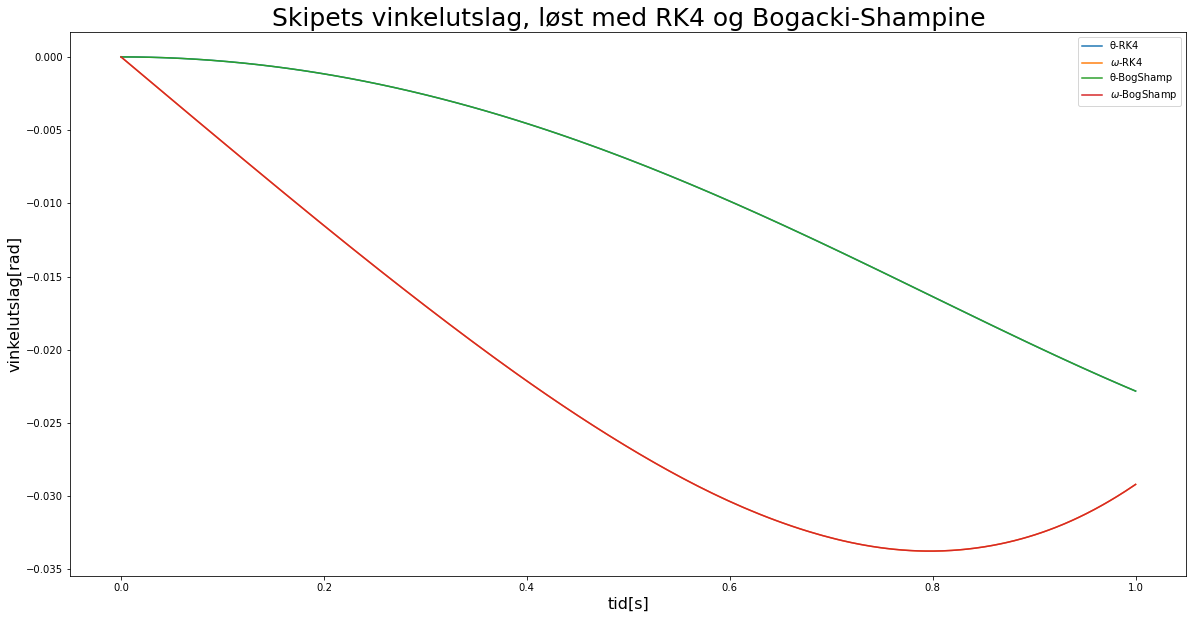

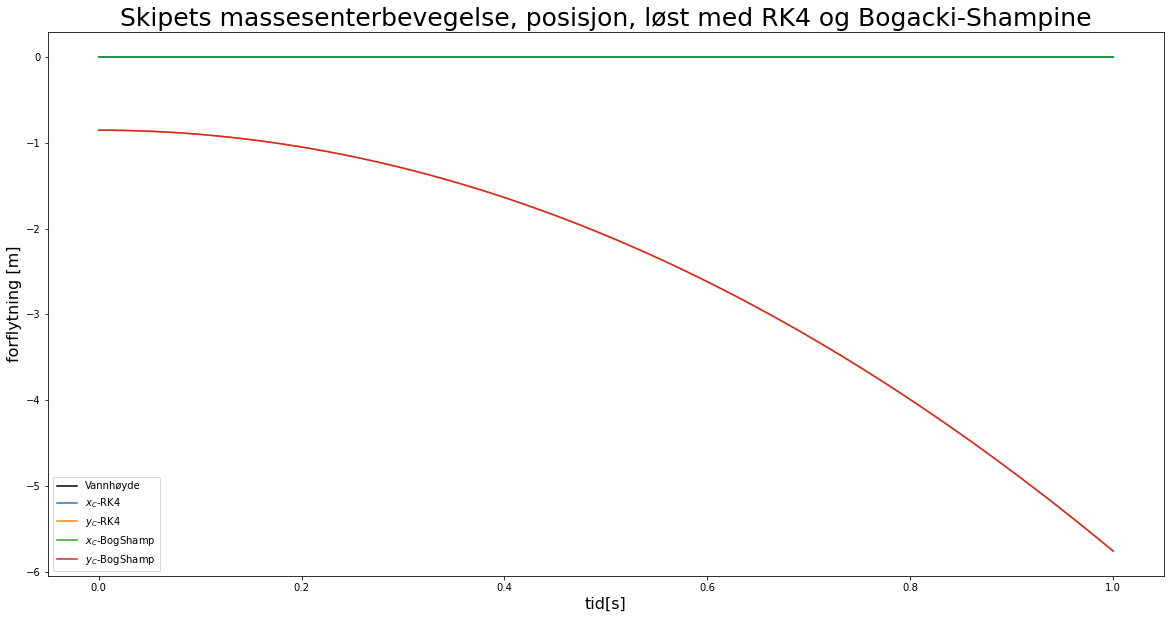

<ipython-input-41-686bf159aea0>:38: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001F8B735D8B0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(['_', '$s_L$-RK4', '$v_L$-RK4', '$s_L$-BogShamp', '$v_L$-BogShamp'])


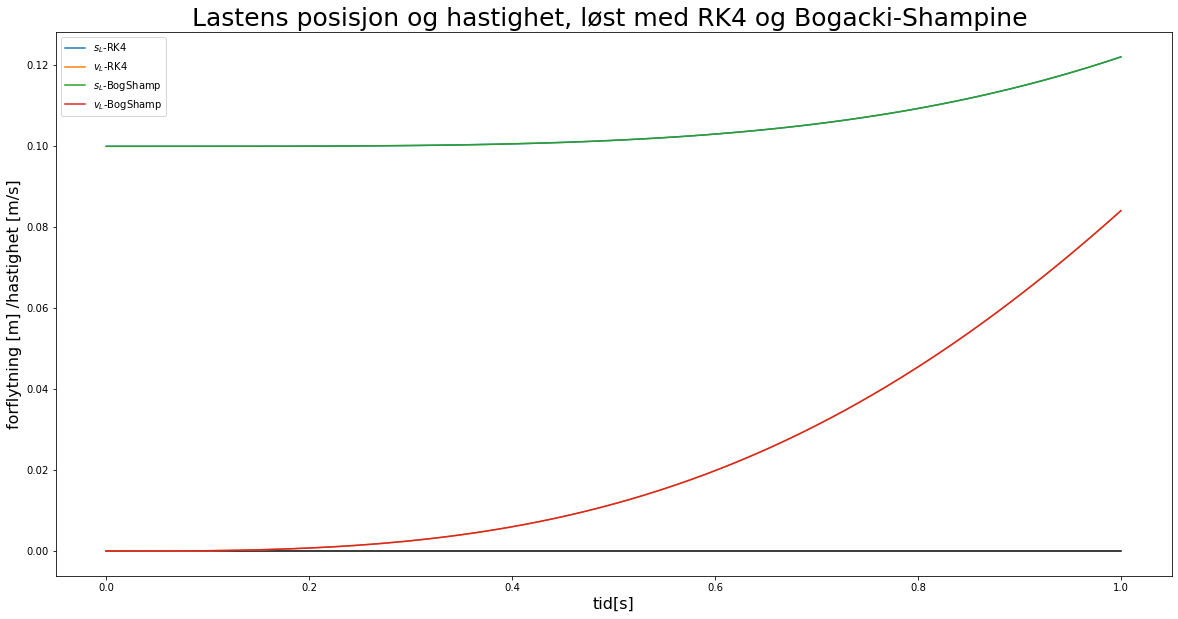

In [41]:
data_Vasa = np.load('Vasa.npz')
data_Vasa_bs = np.load('Vasa_bs.npz')

if data_Vasa['time_lost']!=(-1): print(f"RK4-Lasten traff gjerdet ved t = {data_Vasa['time_lost']:.2f} s")
if data_Vasa['time_cap']!=(-1): print(f"RK4-Skipet kantret ved t = {data_Vasa['time_cap']:.2f} s")
if data_Vasa_bs['time_lost']!=(-1): print(f"BogShamp-Lasten traff gjerdet ved t = {data_Vasa_bs['time_lost']:.2f} s")
if data_Vasa_bs['time_cap']!=(-1): print(f"BogShamp-Skipet kantret ved t = {data_Vasa_bs['time_cap']:.2f} s")

plt.figure(figsize = (20, 10))
plt.plot(data_Vasa['time'], data_Vasa['angles'])
plt.plot(data_Vasa['time'], data_Vasa['angular_velocity'])
plt.plot(data_Vasa_bs['time'], data_Vasa_bs['angles'])
plt.plot(data_Vasa_bs['time'], data_Vasa_bs['angular_velocity'])
plt.title('Skipets vinkelutslag, løst med RK4 og Bogacki-Shampine', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('vinkelutslag[rad]', fontsize = 16)
plt.legend(['θ-RK4', '$\omega$-RK4', 'θ-BogShamp', '$\omega$-BogShamp'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_Vasa_bs['time'], np.full(len(data_Vasa_bs['time']), 0), color = 'k')
plt.plot(data_Vasa['time'], data_Vasa['C_position_x'])
plt.plot(data_Vasa['time'], data_Vasa['C_position_y'])
plt.plot(data_Vasa_bs['time'], data_Vasa_bs['C_position_x'])
plt.plot(data_Vasa_bs['time'], data_Vasa_bs['C_position_y'])
plt.title('Skipets massesenterbevegelse, posisjon, løst med RK4 og Bogacki-Shampine', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m]', fontsize = 16)
plt.legend(['Vannhøyde', '$x_C$-RK4', '$y_C$-RK4', '$x_C$-BogShamp', '$y_C$-BogShamp'])
plt.show()

plt.figure(figsize = (20, 10))
plt.plot(data_Vasa_bs['time'], np.full(len(data_Vasa_bs['time']), 0), color = 'k')
plt.plot(data_Vasa['time'], data_Vasa['cargo_position'])
plt.plot(data_Vasa['time'], data_Vasa['cargo_velocity'])
plt.plot(data_Vasa_bs['time'], data_Vasa_bs['cargo_position'])
plt.plot(data_Vasa_bs['time'], data_Vasa_bs['cargo_velocity'])
plt.title('Lastens posisjon og hastighet, løst med RK4 og Bogacki-Shampine ', fontsize = 25)
plt.xlabel('tid[s]', fontsize = 16); plt.ylabel('forflytning [m] /hastighet [m/s]', fontsize = 16)
plt.legend(['_', '$s_L$-RK4', '$v_L$-RK4', '$s_L$-BogShamp', '$v_L$-BogShamp'])
plt.show()

Vi forsøkte litt forskjellige metoder for å forsøke å løse differentiallikningene for det mer realistiske systemet, men ut fra grafen for massesenterets posisjon ser vi at skipet synker rett til bunn etter kun ett sekund, og alle funksjonalitetene våre feiler da det dukker opp ugyldige verdier i blant annet arccos-funksjonen for beregning av $\gamma$. Vi tenkte fortsatt at det var verdt et forsøk, men det er klart at de mange forenklingene vi har foretatt underveis (for eksempel var ikke Vasaskipet en fylt halvsirkel med konstant massetetthet, ikke var det uendelig langt for å se bortifra endeeffekter, lasten var mye mer komplisert enn én punktmasse som sklir friksjonsfritt og vinden får en lengre kraftarm når den virker i toppen av et seil $20$m over dekk enn kun inn i sida på skroget) forhindrer oss fra å realisere modellen vår til virkeligheten. 

Vi fikk utdelt en animasjonsfunksjon for å visualisere skipets bevegelse, som dessverre ikke kan kjøres i denne notebooken, men som vi kunne kopiere til et annet program for å teste funksjonene våre. Vi benyttet denne funksjonen for å visuelt studere de ulike kreftenes og dreiemomentenes effekt på skipets dynamikk, og det var en nyttig måte å studere om funksjonene vi hadde laget stemte overens med forventede resultater. Underveis kunne vi blant annet oppdage feil i fortegn, ved at lasten begynte å skli oppover dekk, eller at vi hadde glemt å dele på 2 i kantringsbetingelsen, ved at dekk havnet under vann uten at skipet kantret.

#### Konklusjon 

Gjennom dette prosjektet har vi benyttet mekanisk fysikk og vitenskapelige beregninger for å beskrive, visualisere og få en bedre forståelse av hvordan man kan regne på og numerisk approksimere dynamikk som oppstår på grunn av ulike krefter og dreiemoment. Vi har observert effekten av hvordan ulike faktorer og tidsvarierende bidrag vil påvirke stabilitetsegenskaper, gjennom å studere en forenklet skipsmodell. Vi har sett på typiske elementer som vil spille inn på dynammiken til et slikt system, blant annet oppdrift, friksjon og harmoniske krefter fra vind og bølger, og hvordan disse vil resultere i translasjon av og rotasjon om massesenteret til skipet vårt. Vi har spesielt fått nytte av iterative metoder for å numerisk løse de økende komplekse differentiallikningene som beskriver systemet vårt. 

Til tross for at vi i denne oppgaven har forenklet mange beskrivelser og oversett mer realistiske dynamiske elementer som ville vært nødvendig dersom modellen vår skulle bli brukt i virkeligheten, har vi fått en dypere forståelse av hvordan koblede systemer kan løses i praksis ved å benytte numeriske metoder. Vi har dermed fått en viktig erfaring med hvordan man kan utnytte datamaskiners funksjonalitet til å utføre komplekse utregninger, og hvordan vitenskapelige beregninger blir utført i arbeidslivet. 

### Kilder:

R. E. Fairley and M. J. Willshire, "Why the Vasa sank: 10 problems and some antidotes for software projects," in IEEE Software, vol. 20, no. 2, pp. 18-25, March-April 2003, doi: 10.1109/MS.2003.1184161. Tilgjengelig fra: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1184161

Vasamuseet, (2020) "Q&A: Finding the Vasa Cannon". https://www.vasamuseet.se/en/research/finding-the-vasa-cannon/qa [Hentet 11.03.2022]

Engineering ToolBox, (2003). "Air - Density, Specific Weight and Thermal Expansion Coefficient vs. Temperature and Pressure". [online] Available at: https://www.engineeringtoolbox.com/air-density-specific-weight-d_600.html [Hentet 11.03. 2022].

Javier, D-Z, I. et al. (2019) "TEST OF WOOD PROPERTIES IN OAK SPECIES (QUERCUS ROBUR L., QUERCUS PETRAEA (MATTS) LIEBL. AND QUERCUS PYRENAICA WILLD.) FOR WINE AGING. PART III: POROSITY VERSUS VOID RATIO" http://www.woodresearch.sk/wr/201905/08.pdf [Hentet 11.03.2022]

Ljungdahl, J. (2006) "Structure and Properties of Vasa Oak" https://www.diva-portal.org/smash/get/diva2:10398/FULLTEXT01.pdf [Hentet 11.03.2022]

Wisting, Tor: Vasa - skip i Store norske leksikon på snl.no. https://snl.no/Vasa_-_skip [Hentet 11.03.2022]